In [722]:
# %pip install git+https://github.com/tensorflow/docs

import requests
import os.path
import asyncio
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from riotwatcher import TftWatcher, ApiError

from utils.configuration import settings
from utils.utils import *
from tft.api import *

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(10, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


In [723]:
API_KEY = settings.api_key
ASSETS_DIR = settings.assets_dir
SERVER = 'euw1'  # euw1 na1 kr oc1
LEAGUE='challengers'
MAX_COUNT = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196'

TARGETNAME = 'placement'

In [724]:
raw_df = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_matches.pickle'))

In [725]:
raw_df

,match_id,placement,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Dragonmancer,Set7_Guild,...,TFT7_Skarner_item0,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2
0,EUW1_5944909932,2,TFT6_Augment_TrueTwos,TFT6_Augment_CyberneticImplants2,TFT6_Augment_SecondWind2,1.0,1.0,2.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EUW1_5944909932,1,TFT6_Augment_PortableForge,TFT6_Augment_SalvageBin,TFT6_Augment_TargetDummies,NaN,0.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EUW1_5944909932,3,TFT7_Augment_AssassinEmblem,TFT6_Augment_TradeSectorPlus,TFT7_Augment_ScalescornEmblem,3.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EUW1_5944909932,4,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_RichGetRicherPlus,TFT7_Augment_BestFriends2,1.0,1.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EUW1_5944909932,7,TFT7_Augment_PandorasBench,TFT7_Augment_MikaelsGift,TFT6_Augment_SalvageBin,2.0,1.0,NaN,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11251,EUW1_5941855898,6,TFT7_Augment_BestFriends2,TFT7_Augment_MirageEmblem,TFT6_Augment_ComponentGrabBag,NaN,NaN,3.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11252,EUW1_5941855898,7,TFT6_Augment_HyperRoll,TFT6_Augment_ComponentGrabBag,TFT7_Augment_GuardianHeroicPresence,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11253,EUW1_5941855898,1,TFT7_Augment_UrfsGrabBag1,TFT6_Augment_TriForce2,TFT7_Augment_ScalescornEmblem,2.0,1.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11254,EUW1_5941855898,8,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_TradeSectorPlus,TFT6_Augment_Diversify2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [726]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [727]:
raw_df = reduce_mem_usage(raw_df)

Mem. usage decreased to 19.12 Mb (16.6% reduction)


In [728]:
raw_df[raw_df['match_id'].duplicated()]

,match_id,placement,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Dragonmancer,Set7_Guild,...,TFT7_Skarner_item0,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2
1,EUW1_5944909932,1,TFT6_Augment_PortableForge,TFT6_Augment_SalvageBin,TFT6_Augment_TargetDummies,NaN,0.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EUW1_5944909932,3,TFT7_Augment_AssassinEmblem,TFT6_Augment_TradeSectorPlus,TFT7_Augment_ScalescornEmblem,3.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EUW1_5944909932,4,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_RichGetRicherPlus,TFT7_Augment_BestFriends2,1.0,1.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EUW1_5944909932,7,TFT7_Augment_PandorasBench,TFT7_Augment_MikaelsGift,TFT6_Augment_SalvageBin,2.0,1.0,NaN,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EUW1_5944909932,5,TFT6_Augment_SunfireBoard,TFT6_Augment_Distancing2,TFT7_Augment_GadgetExpert,NaN,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11251,EUW1_5941855898,6,TFT7_Augment_BestFriends2,TFT7_Augment_MirageEmblem,TFT6_Augment_ComponentGrabBag,NaN,NaN,3.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11252,EUW1_5941855898,7,TFT6_Augment_HyperRoll,TFT6_Augment_ComponentGrabBag,TFT7_Augment_GuardianHeroicPresence,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11253,EUW1_5941855898,1,TFT7_Augment_UrfsGrabBag1,TFT6_Augment_TriForce2,TFT7_Augment_ScalescornEmblem,2.0,1.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11254,EUW1_5941855898,8,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_TradeSectorPlus,TFT6_Augment_Diversify2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [729]:
def check_NA(df):
    missing_val = df.isnull().sum()
    print(missing_val[missing_val > 0])

In [730]:
# Check NA
check_NA(raw_df)

augment0                      16
augment1                      51
augment2                      88
Set7_Assassin               7438
Set7_Bruiser                4489
                           ...  
TFT7_Senna_item1           11226
TFT7_Senna_item2           11240
TFT7_Heimerdinger_item2    11243
TFT7_Aatrox_item1          11219
TFT7_Aatrox_item2          11231
Length: 265, dtype: int64


In [731]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [732]:
raw_df = impute(raw_df)

In [733]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

In [734]:
def check_categorical_cols(df):
    print('Values along with Count in the Categorical Columns','\n')
    for i in categorical_cols:
        print(i)
        print(df[i].value_counts(),'\n')  

In [735]:
check_categorical_cols(raw_df)

Values along with Count in the Categorical Columns 

match_id
EUW1_5944909932    8
EUW1_5940785730    8
EUW1_5942050536    8
EUW1_5941410877    8
EUW1_5940821839    8
                  ..
EUW1_5943246040    8
EUW1_5945715932    8
EUW1_5944765649    8
EUW1_5941172373    8
EUW1_5941855898    8
Name: match_id, Length: 1407, dtype: int64 

augment0
TFT6_Augment_PortableForge           528
TFT7_Augment_UrfsGrabBag1            359
TFT6_Augment_TrueTwos                329
TFT6_Augment_SecondWind2             314
TFT6_Augment_Ascension               296
                                    ... 
TFT7_Augment_ShimmerscaleSpending      1
TFT7_Augment_AFKHR                     1
TFT7_Augment_Preparation1HR            1
TFT6_Augment_FuturePeepers2            1
TFT7_Augment_MageConferenceHR          1
Name: augment0, Length: 189, dtype: int64 

augment1
TFT6_Augment_SecondWind1           439
TFT6_Augment_TinyTitans            410
TFT6_Augment_PortableForge         362
TFT6_Augment_ComponentGrabBag   

In [736]:
# raw_df.arrival_day = pd.to_numeric(raw_df.arrival_day, errors='coerce').astype('int64')
# raw_df[TARGETNAME] = raw_df[TARGETNAME].astype(bool)

In [737]:
raw_df.describe()

,placement,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Dragonmancer,Set7_Guild,Set7_Legend,Set7_Mirage,Set7_Ragewing,Set7_Swiftshot,...,TFT7_Senna,TFT7_Vladimir,TFT7_Heimerdinger,TFT7_Nami,TFT7_Ryze,TFT7_Sylas,TFT7_DragonPurple,TFT7_TahmKench,TFT7_AurelionSol,TFT7_Aatrox
count,11256.00000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,...,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000,11256.000000
mean,4.50000,0.362296,0.505952,0.289446,0.460021,0.993337,0.034471,0.209577,0.441720,0.314677,...,0.022122,0.055526,0.144012,0.159026,0.122512,0.297441,0.054549,0.068852,0.009506,0.025231
std,2.29139,0.732598,0.693410,0.684212,0.789199,1.237160,0.182442,0.728588,0.659265,0.515716,...,0.212345,0.348162,0.515211,0.620352,0.502332,0.713154,0.319165,0.358639,0.117724,0.220422
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.75000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.50000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.25000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.00000,3.000000,4.000000,4.000000,3.000000,6.000000,1.000000,4.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [738]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11256 entries, 0 to 11255
Columns: 267 entries, match_id to TFT7_Aatrox_item2
dtypes: float32(87), int8(1), object(179)
memory usage: 19.1+ MB


2022-06-29 12:36:39,853 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


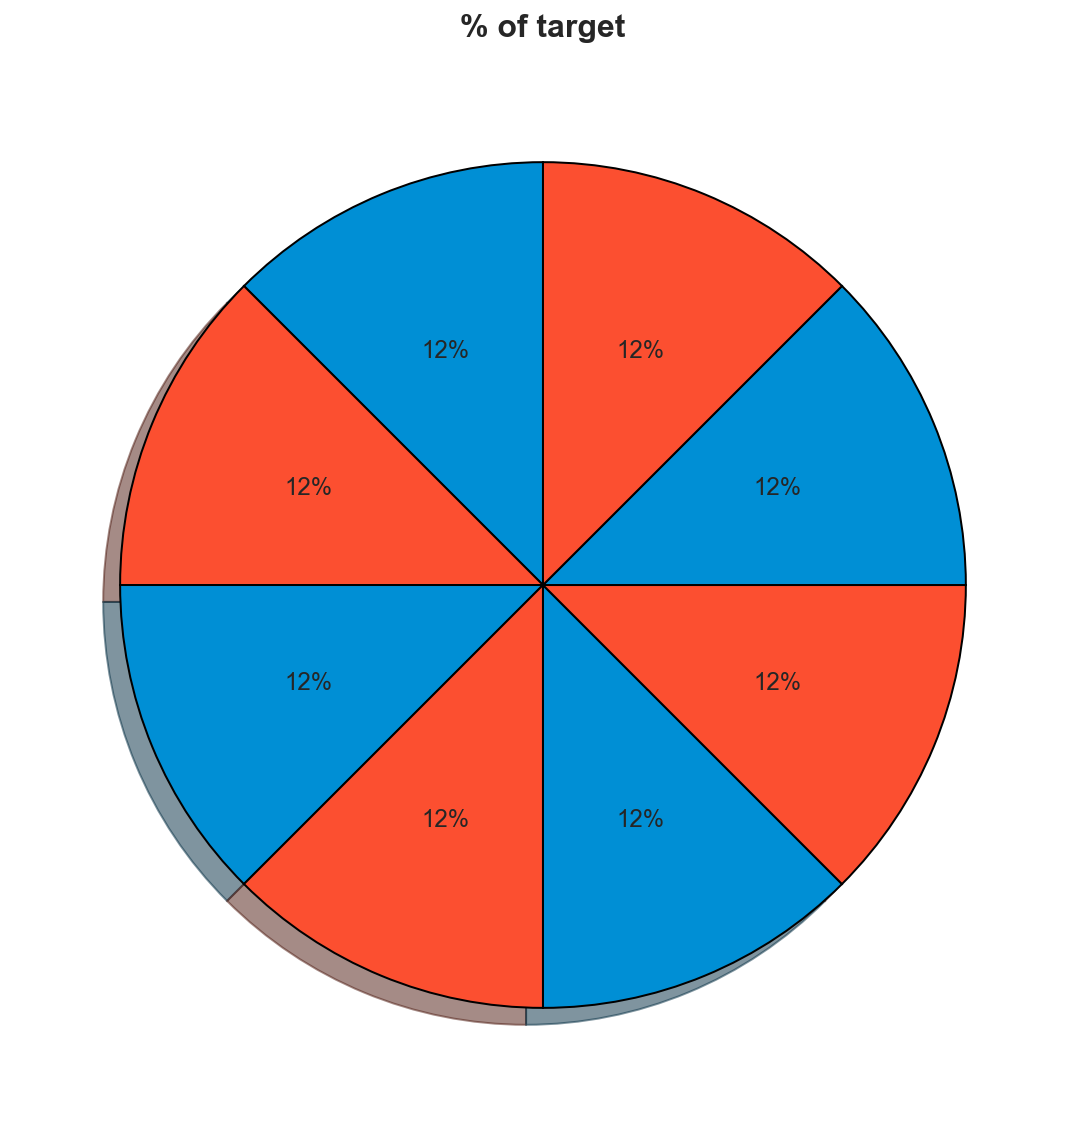

In [739]:
target_count = raw_df[TARGETNAME].value_counts().to_frame().T

colors = ['#008fd5', '#fc4f30']
plt.figure(figsize=(8,8))
plt.title('% of target')
plt.tight_layout()
plt.pie(list(target_count.iloc[0].values), startangle=90, wedgeprops={'edgecolor': 'black'}, colors=colors, autopct='%1.f%%', shadow=True)
plt.legend(loc='best', fontsize='medium')
plt.show()

In [740]:
X = raw_df.drop(['match_id'], axis=1)


In [741]:
y = X.pop(TARGETNAME)

In [742]:
X.fillna('', inplace=True)

In [743]:
X.dtypes

augment0                    object
augment1                    object
augment2                    object
Set7_Assassin              float32
Set7_Bruiser               float32
                            ...   
TFT7_Senna_item1            object
TFT7_Senna_item2            object
TFT7_Heimerdinger_item2     object
TFT7_Aatrox_item1           object
TFT7_Aatrox_item2           object
Length: 265, dtype: object

In [744]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [745]:
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

In [746]:
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [747]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11256 entries, 0 to 11255
Columns: 265 entries, augment0 to TFT7_Aatrox_item2
dtypes: int64(87), object(178)
memory usage: 22.8+ MB


In [748]:
X

,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Dragonmancer,Set7_Guild,Set7_Legend,Set7_Mirage,...,TFT7_Skarner_item0,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2
0,TFT6_Augment_TrueTwos,TFT6_Augment_CyberneticImplants2,TFT6_Augment_SecondWind2,1,1,2,0,3,0,0,...,,,,,,,,,,
1,TFT6_Augment_PortableForge,TFT6_Augment_SalvageBin,TFT6_Augment_TargetDummies,0,0,0,2,0,0,0,...,,,,,,,,,,
2,TFT7_Augment_AssassinEmblem,TFT6_Augment_TradeSectorPlus,TFT7_Augment_ScalescornEmblem,3,1,0,0,1,0,0,...,,,,,,,,,,
3,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_RichGetRicherPlus,TFT7_Augment_BestFriends2,1,1,1,0,3,0,0,...,,,,,,,,,,
4,TFT7_Augment_PandorasBench,TFT7_Augment_MikaelsGift,TFT6_Augment_SalvageBin,2,1,0,0,2,0,0,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11251,TFT7_Augment_BestFriends2,TFT7_Augment_MirageEmblem,TFT6_Augment_ComponentGrabBag,0,0,3,0,2,0,3,...,,,,,,,,,,
11252,TFT6_Augment_HyperRoll,TFT6_Augment_ComponentGrabBag,TFT7_Augment_GuardianHeroicPresence,0,0,0,0,0,0,0,...,,,,,,,,,,
11253,TFT7_Augment_UrfsGrabBag1,TFT6_Augment_TriForce2,TFT7_Augment_ScalescornEmblem,2,1,0,0,1,0,0,...,,,,,,,,,,
11254,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_TradeSectorPlus,TFT6_Augment_Diversify2,0,0,0,0,0,0,0,...,,,,,,,,,,


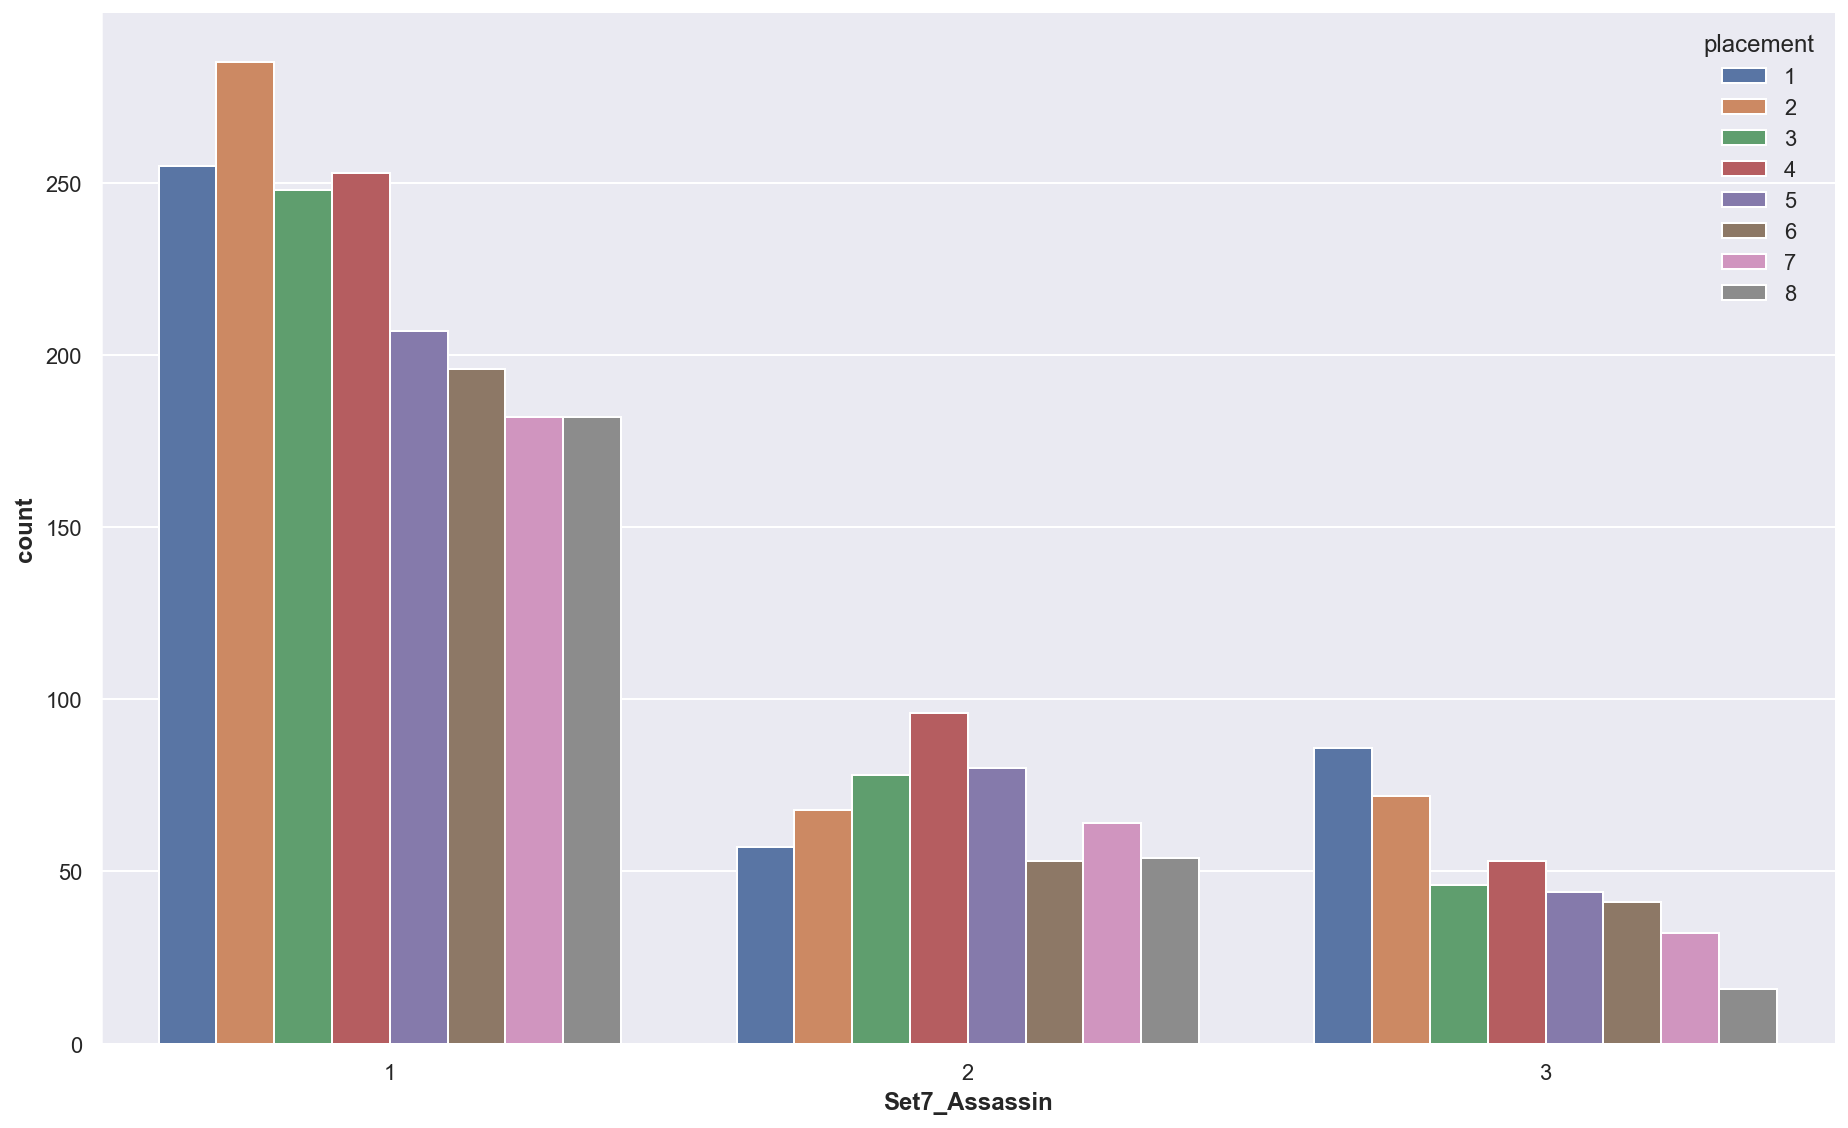

In [749]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Assassin']>0], x='Set7_Assassin', hue=TARGETNAME)
sns.despine()

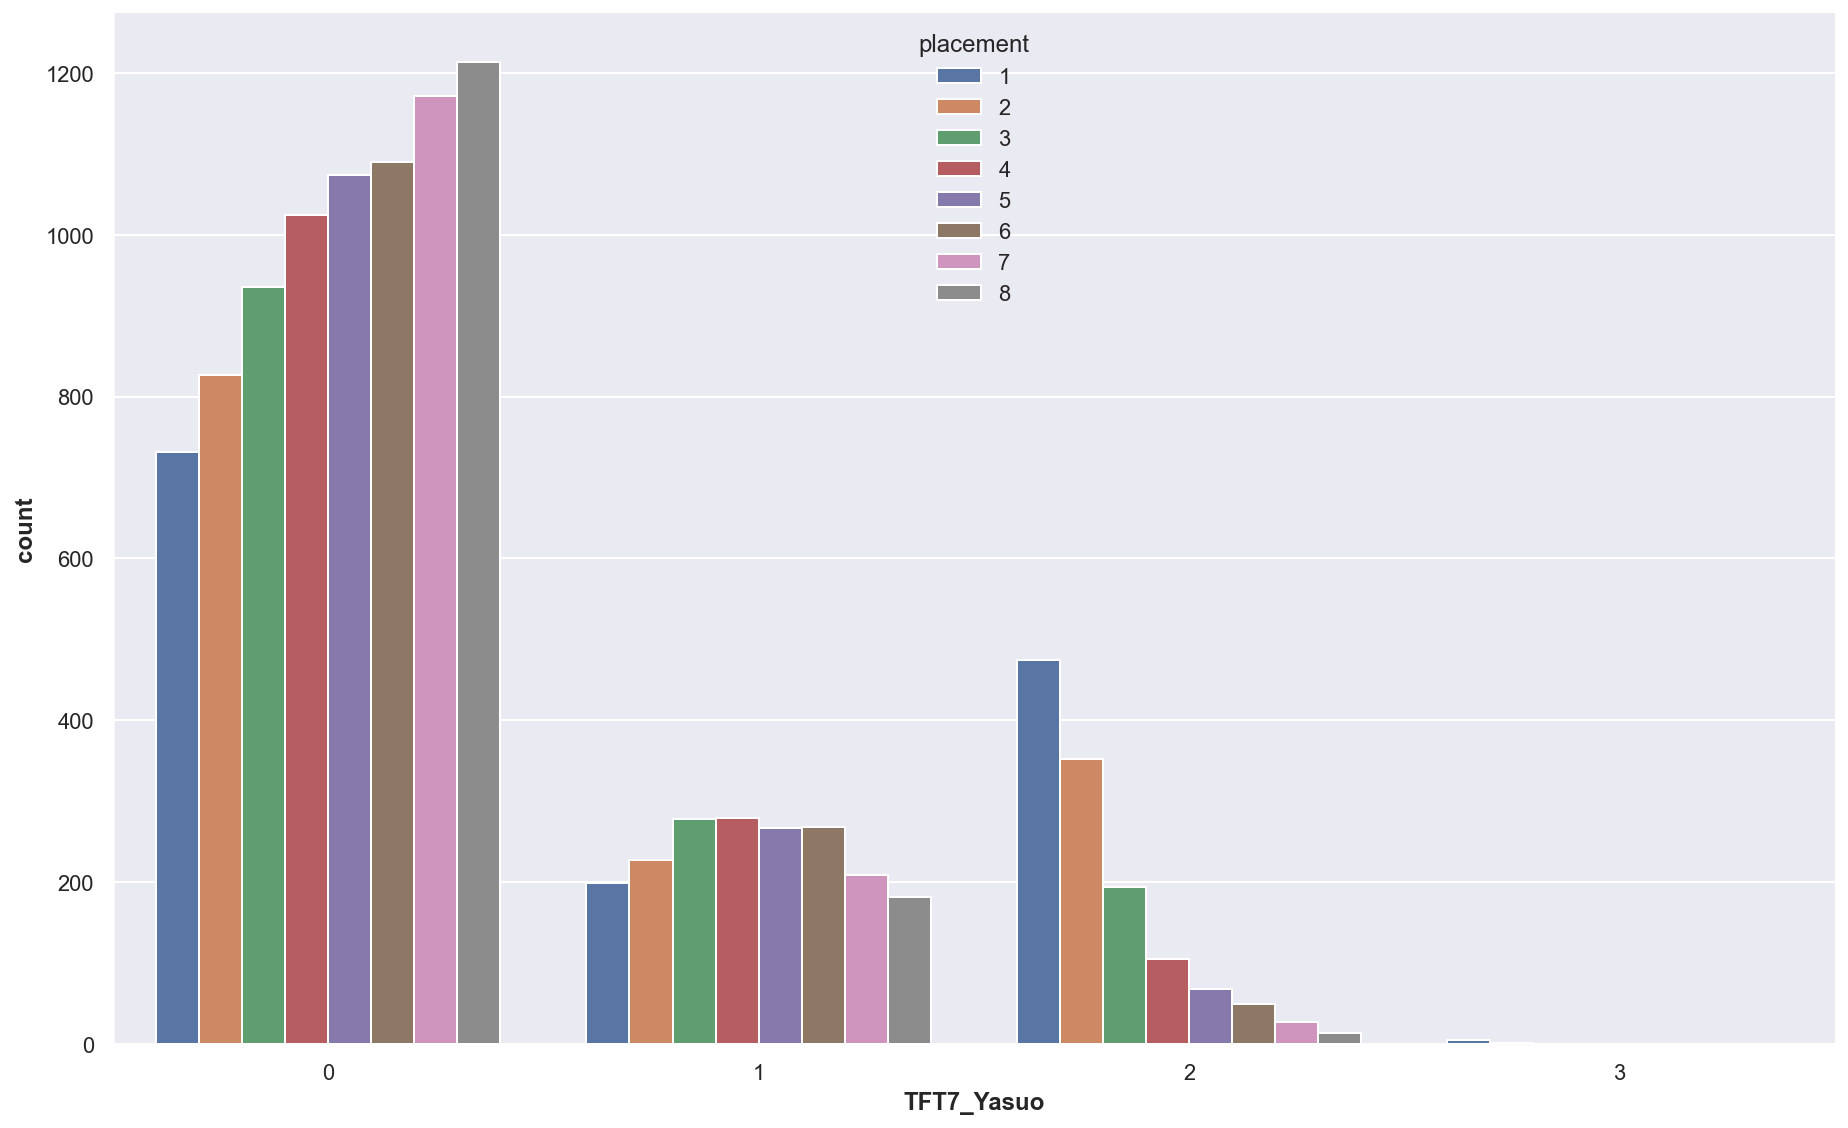

In [750]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Yasuo', hue=TARGETNAME)
sns.despine()

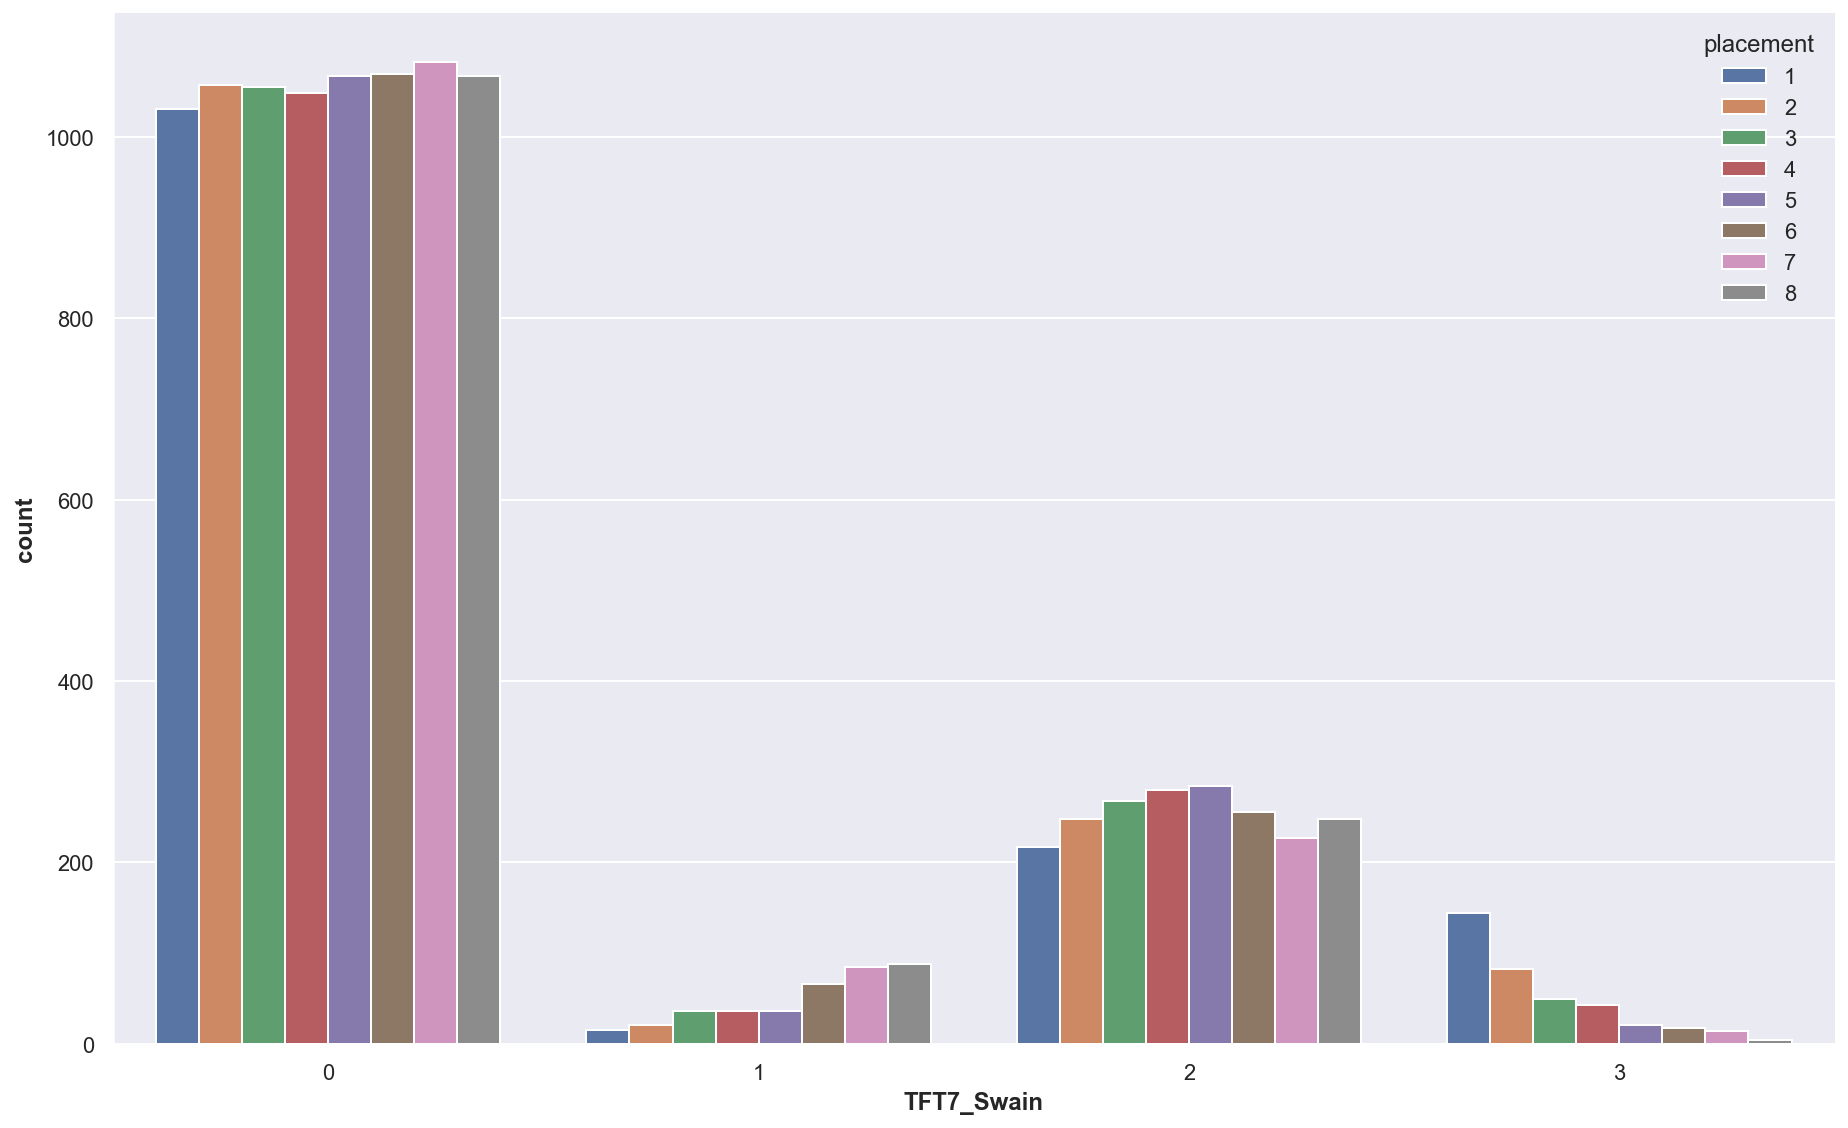

In [751]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Swain', hue=TARGETNAME)
sns.despine()

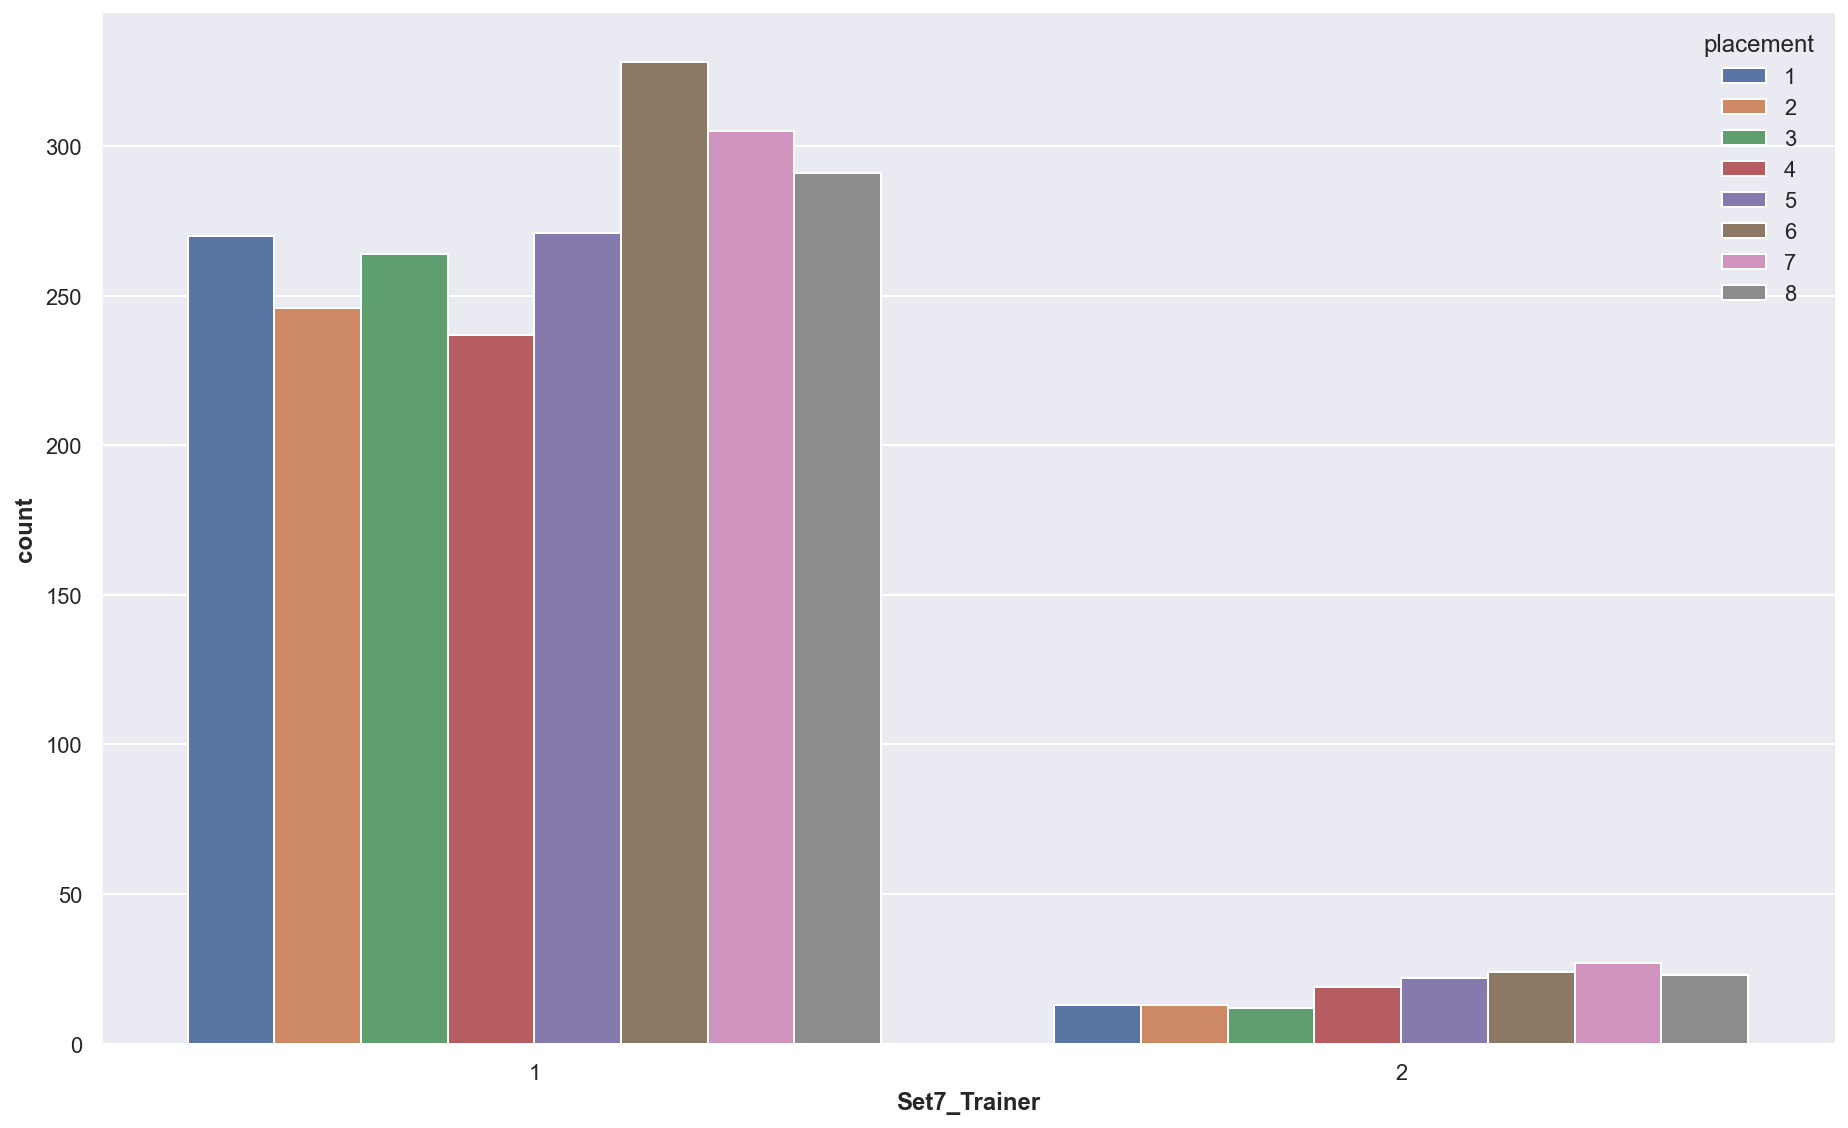

In [752]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Trainer']>0], x='Set7_Trainer', hue=TARGETNAME)
sns.despine()

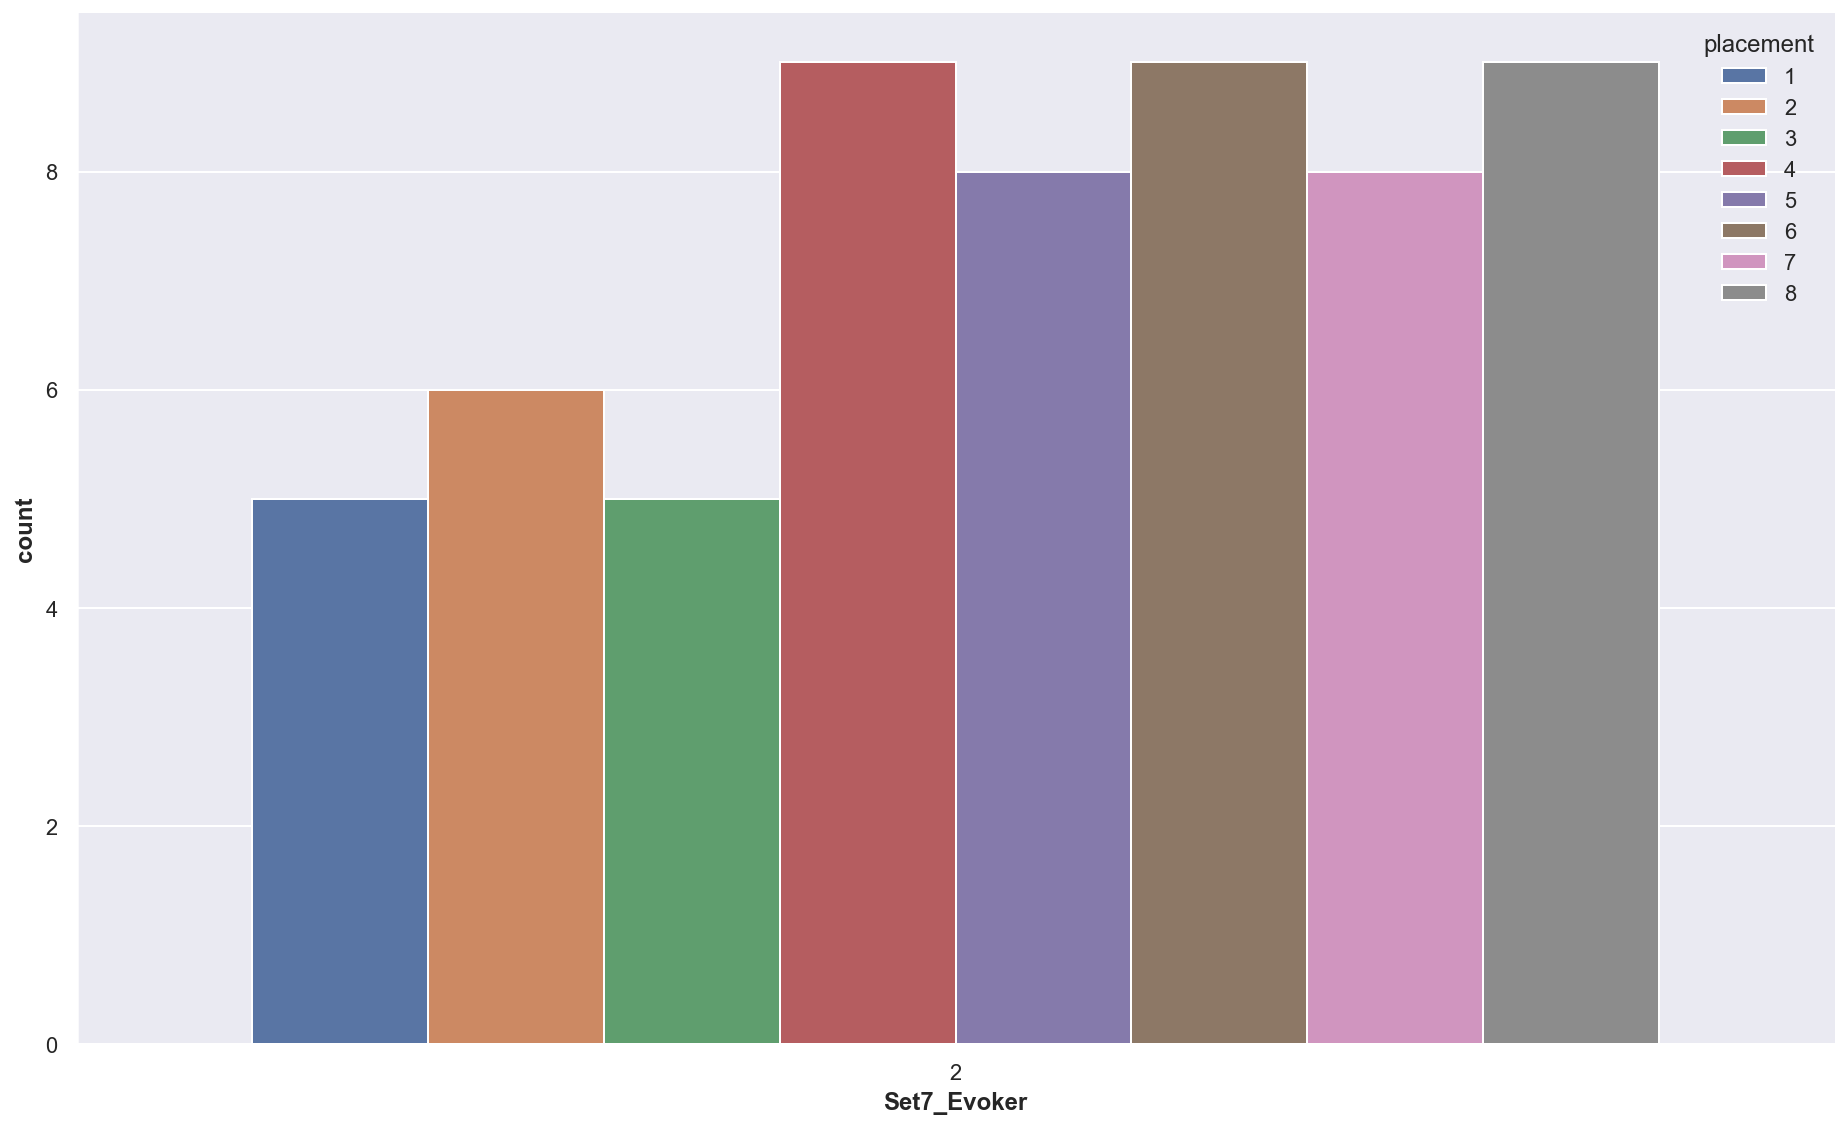

In [753]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Evoker']>1], x='Set7_Evoker', hue=TARGETNAME)
sns.despine()

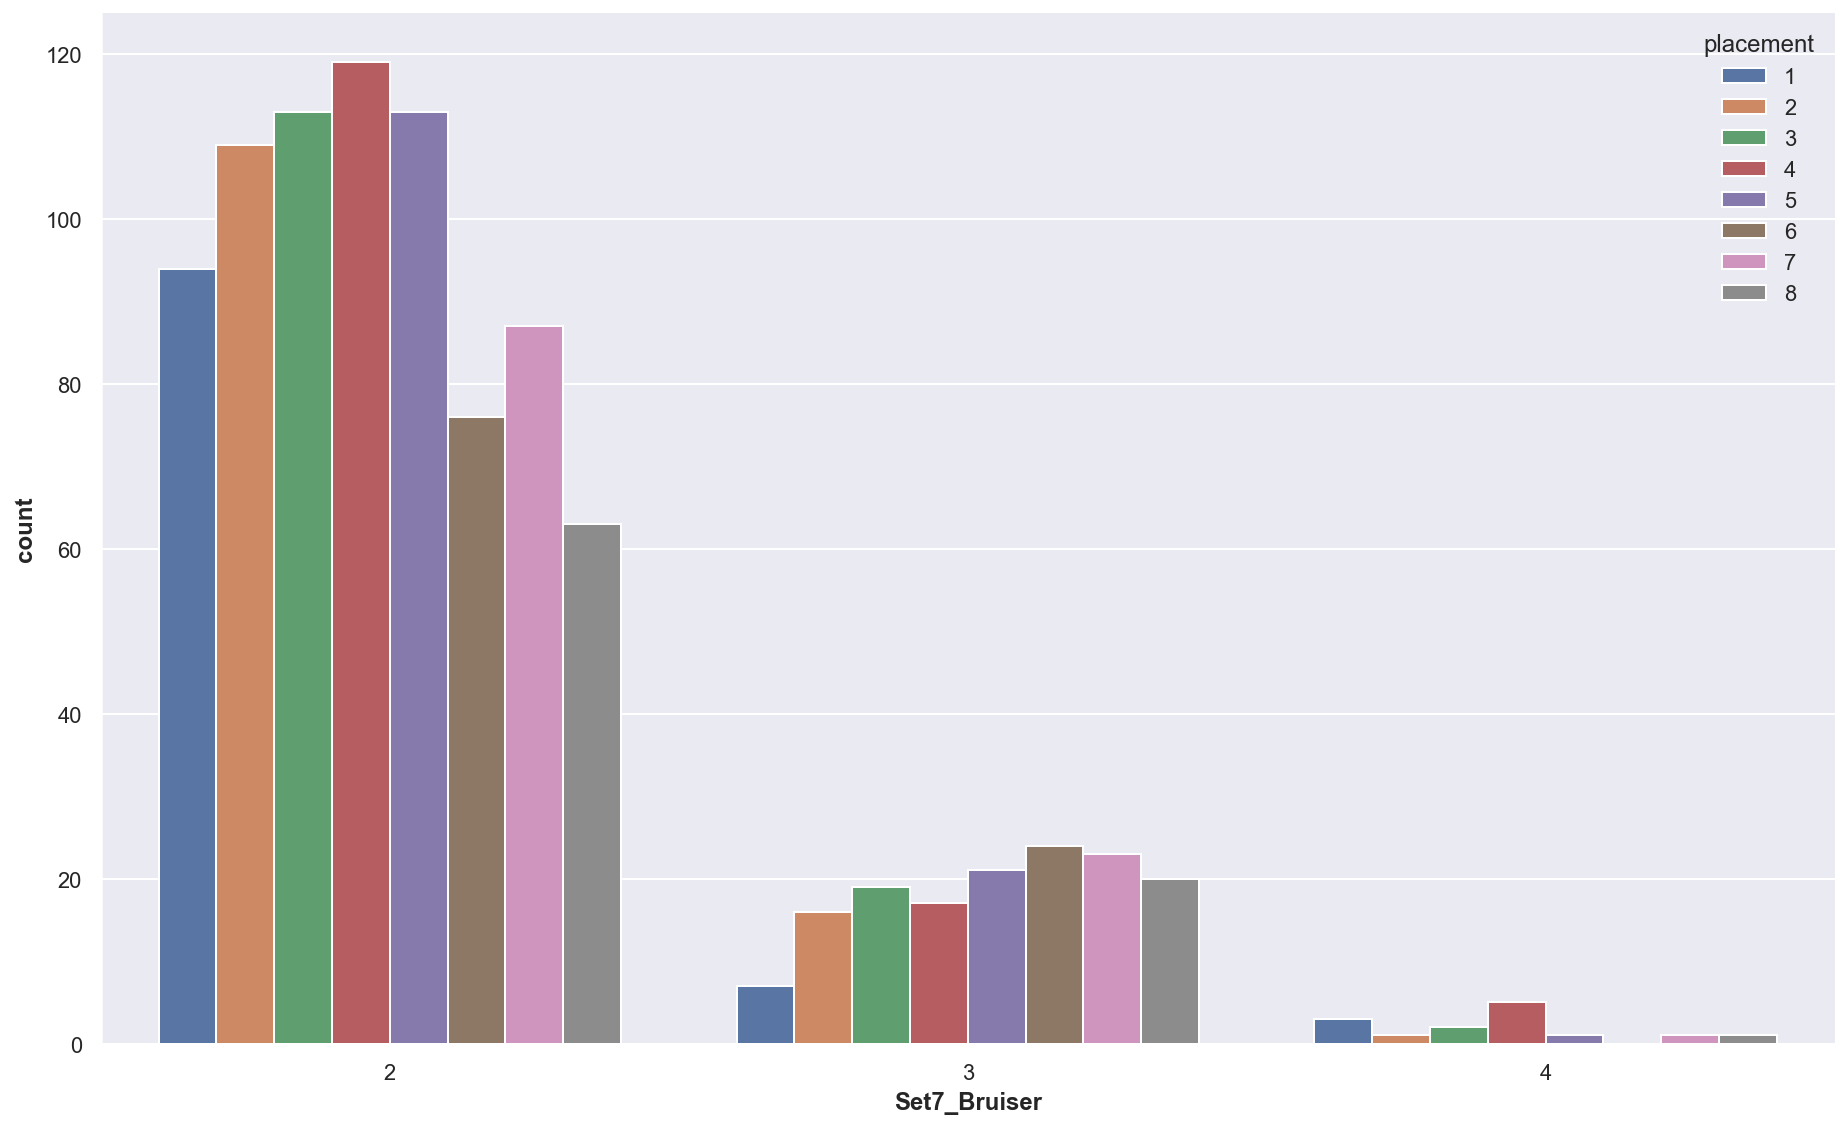

In [754]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Bruiser']>1], x='Set7_Bruiser', hue=TARGETNAME)
sns.despine()

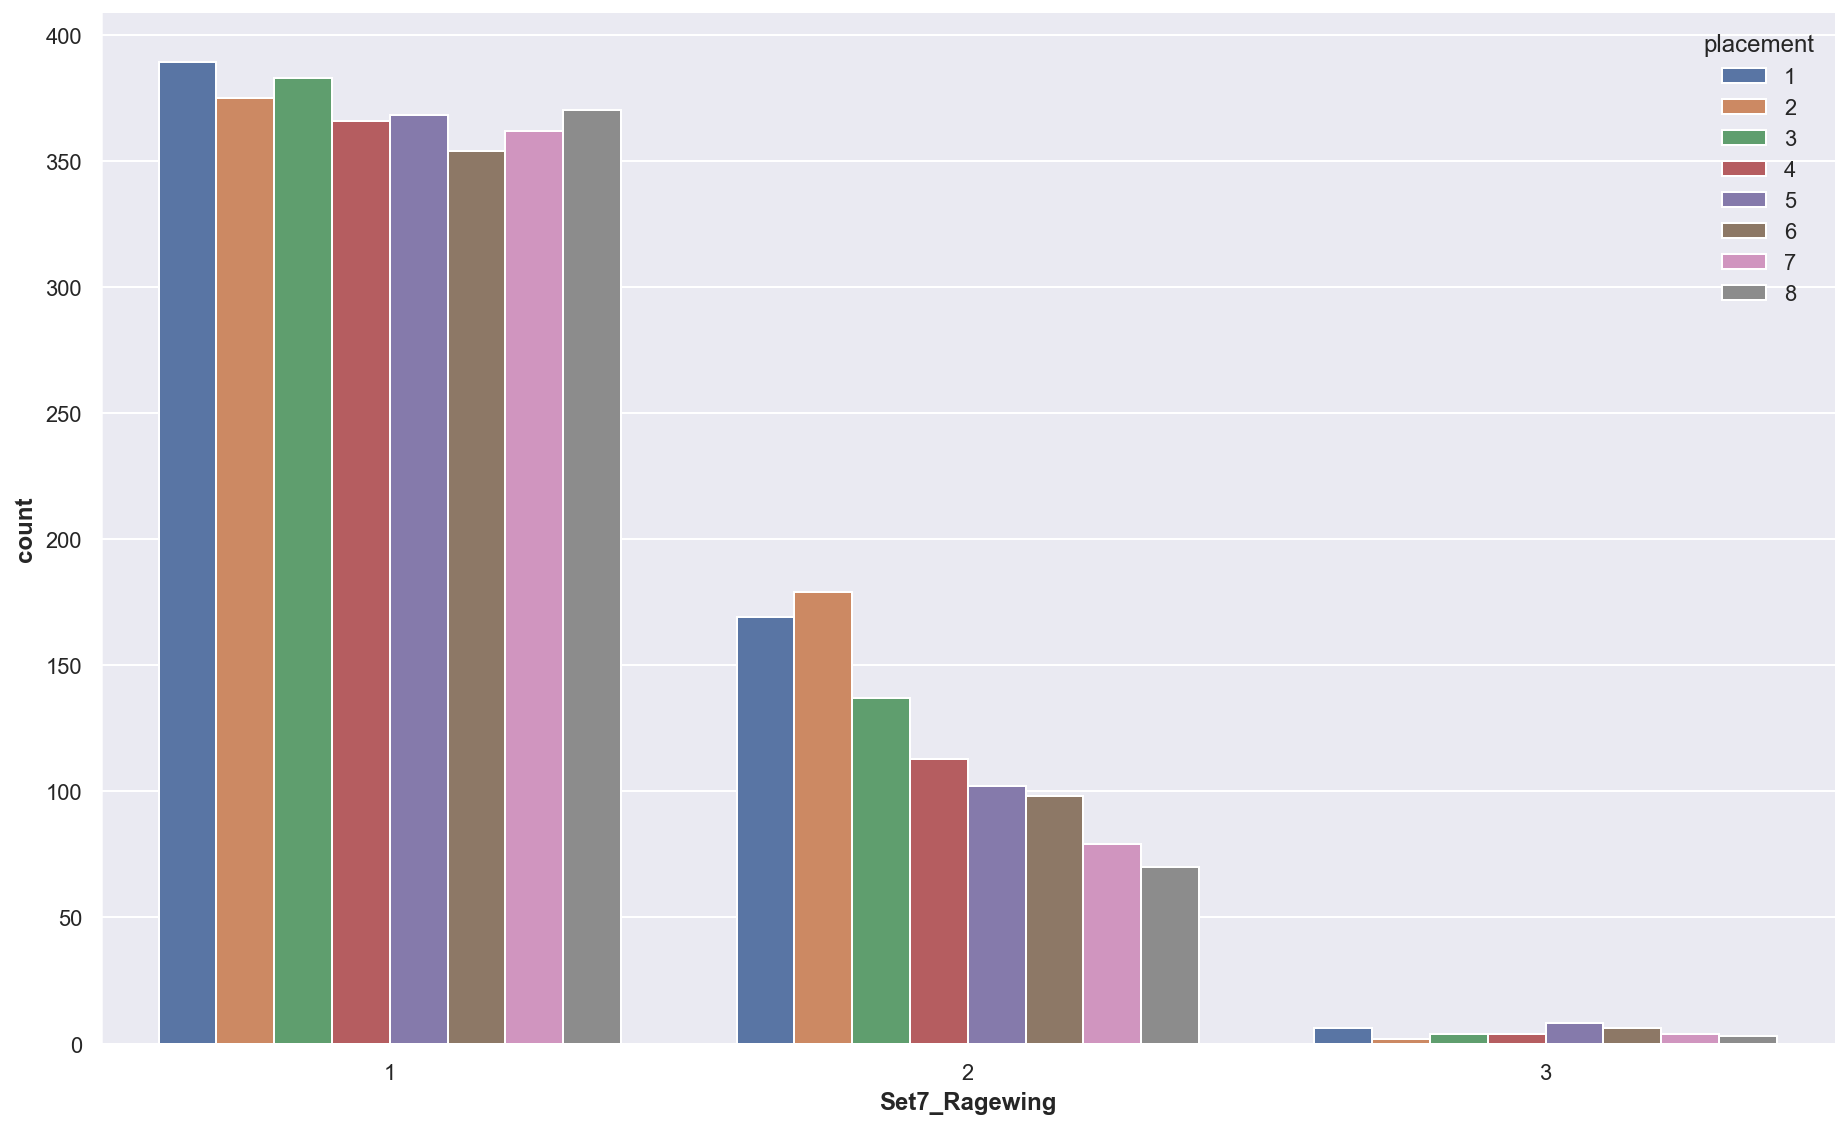

In [755]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Ragewing']>0], x='Set7_Ragewing', hue=TARGETNAME)
sns.despine()

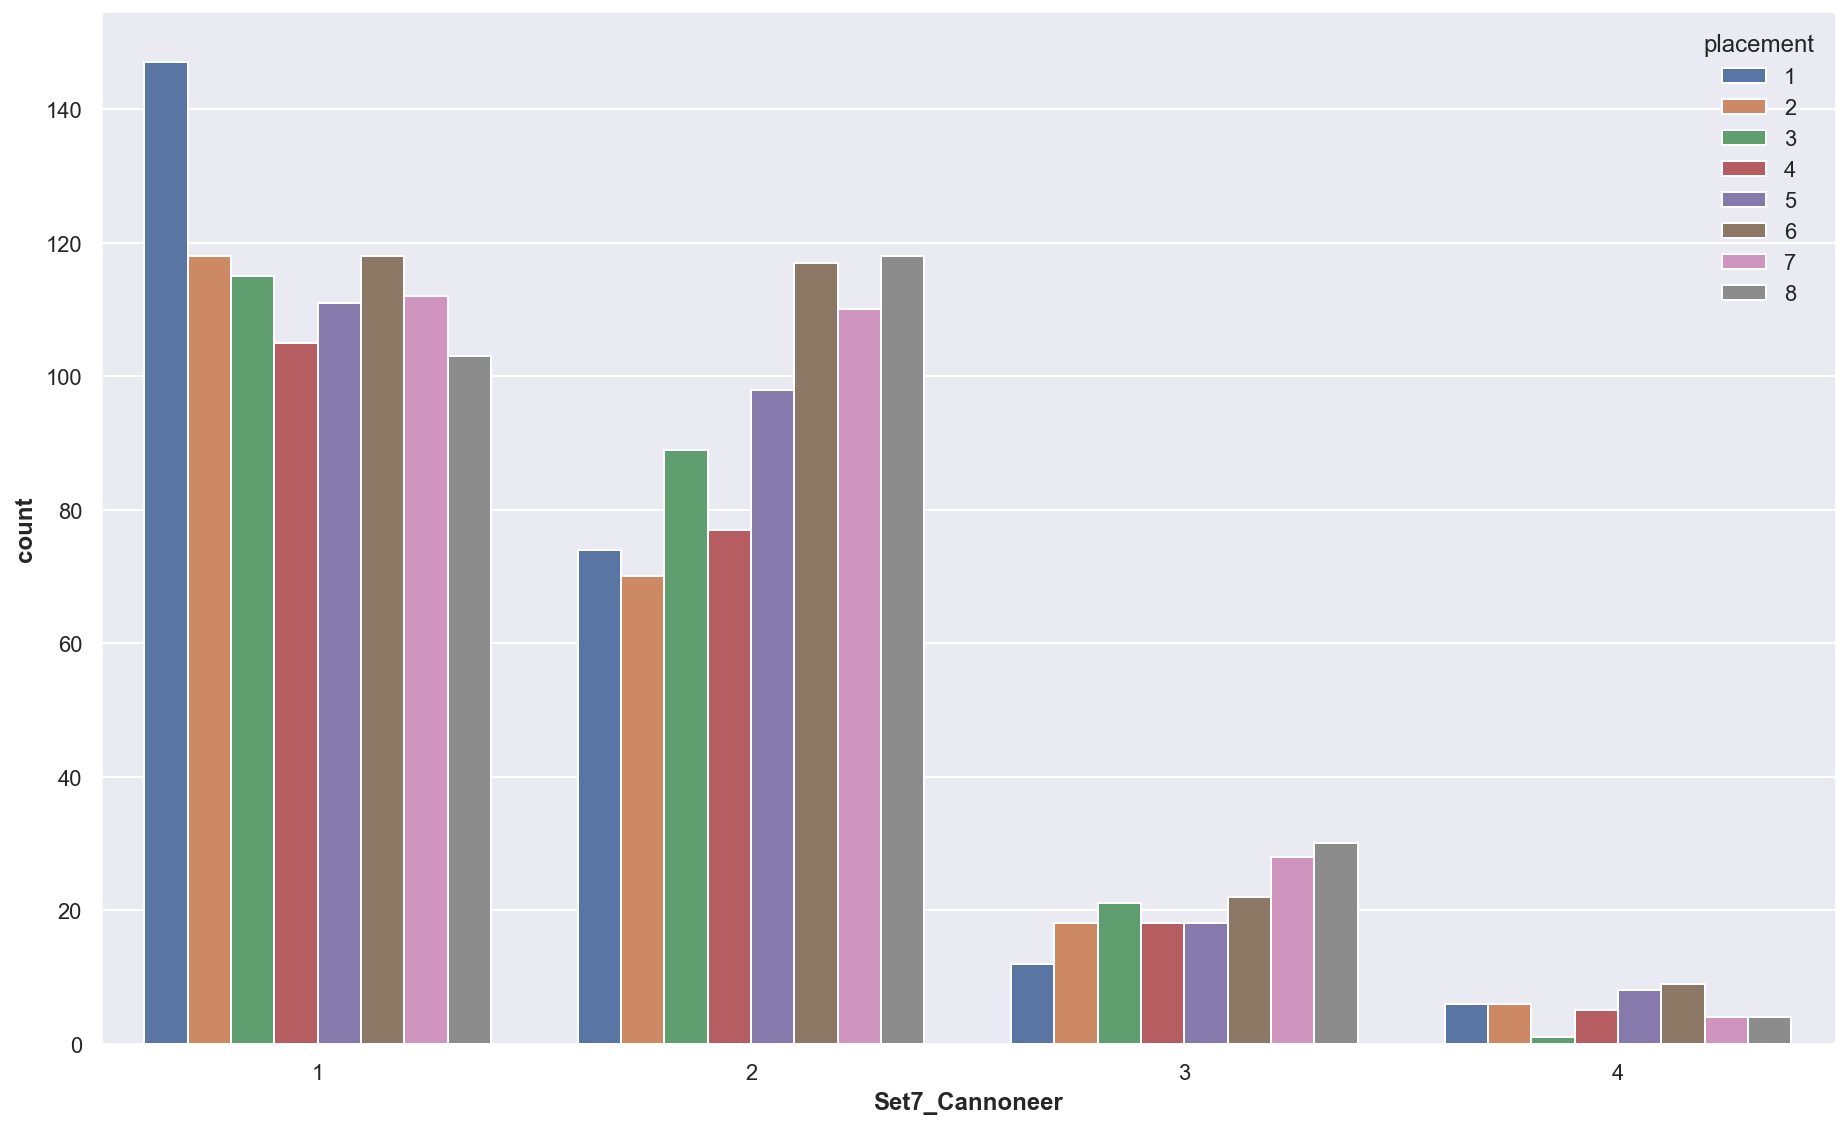

In [756]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Cannoneer']>0], x='Set7_Cannoneer', hue=TARGETNAME)
sns.despine()

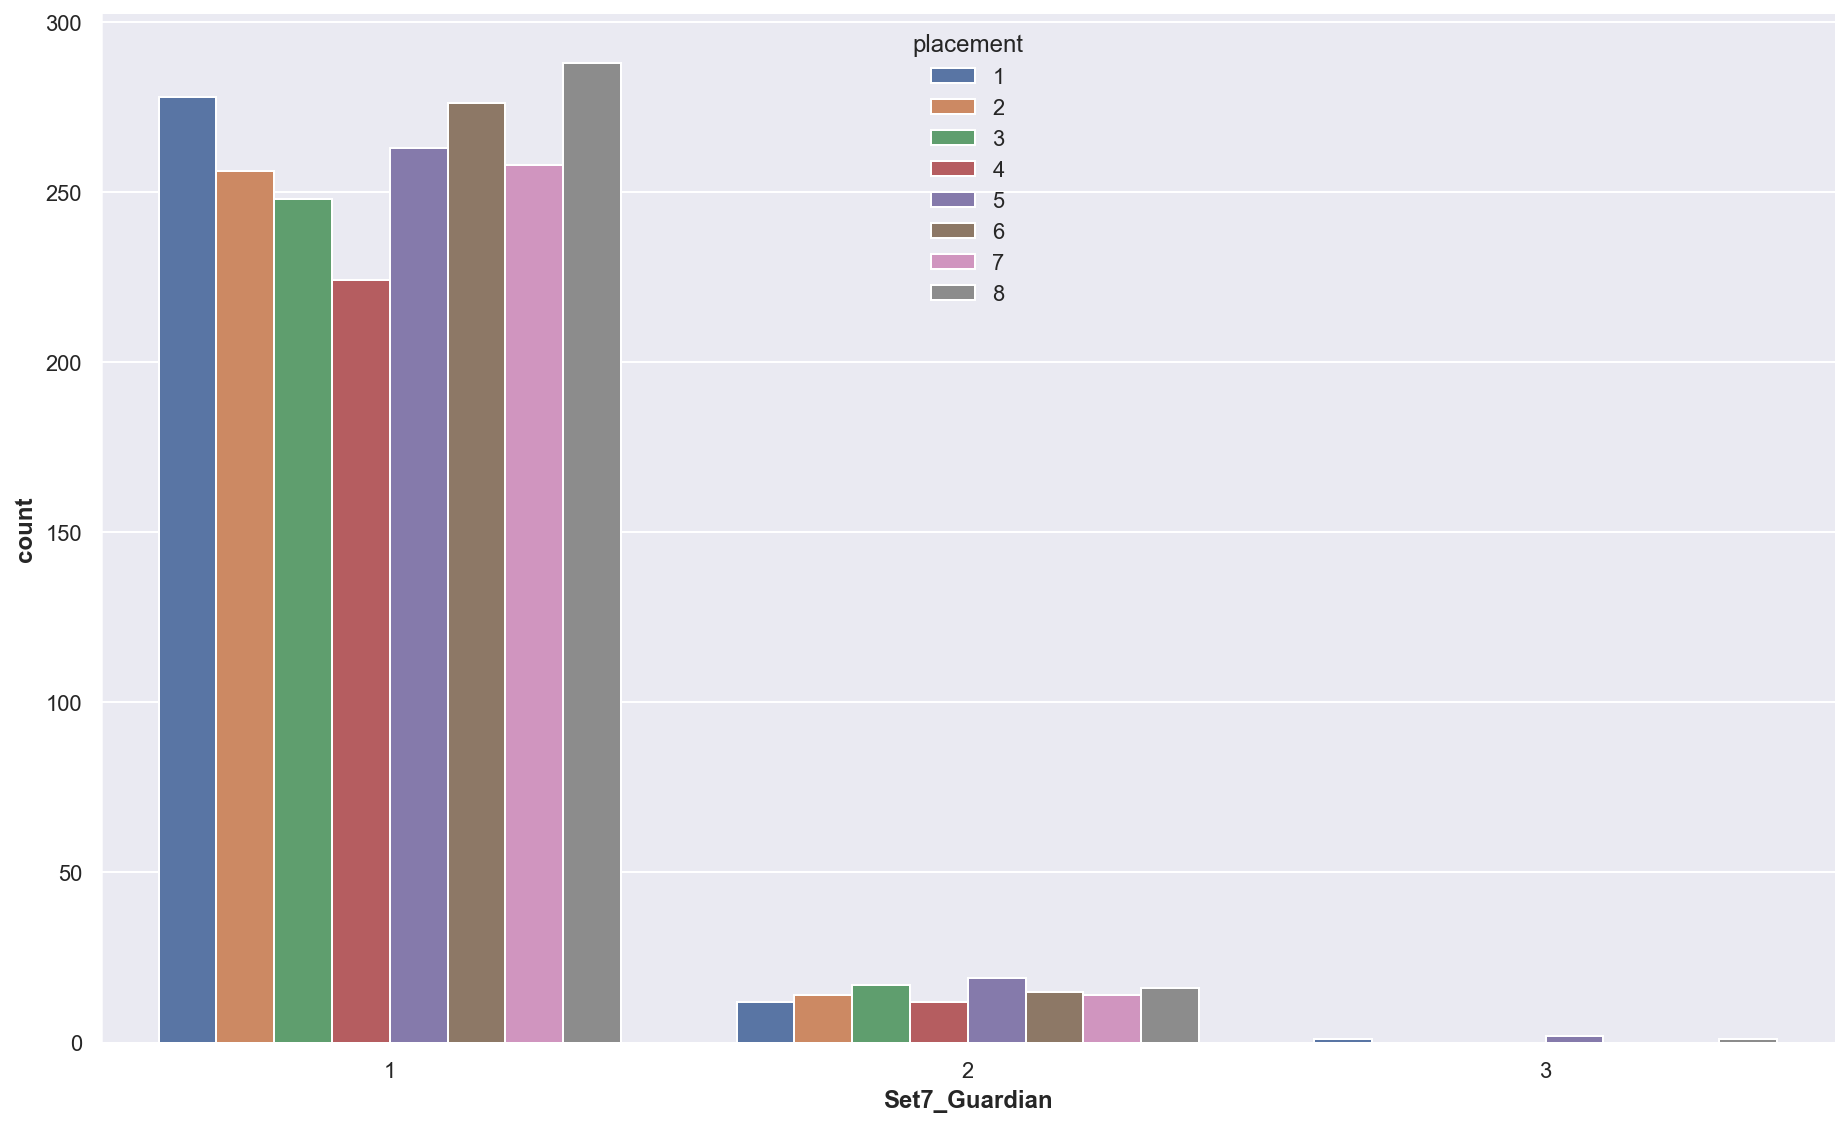

In [757]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Guardian']>0], x='Set7_Guardian', hue=TARGETNAME)
sns.despine()

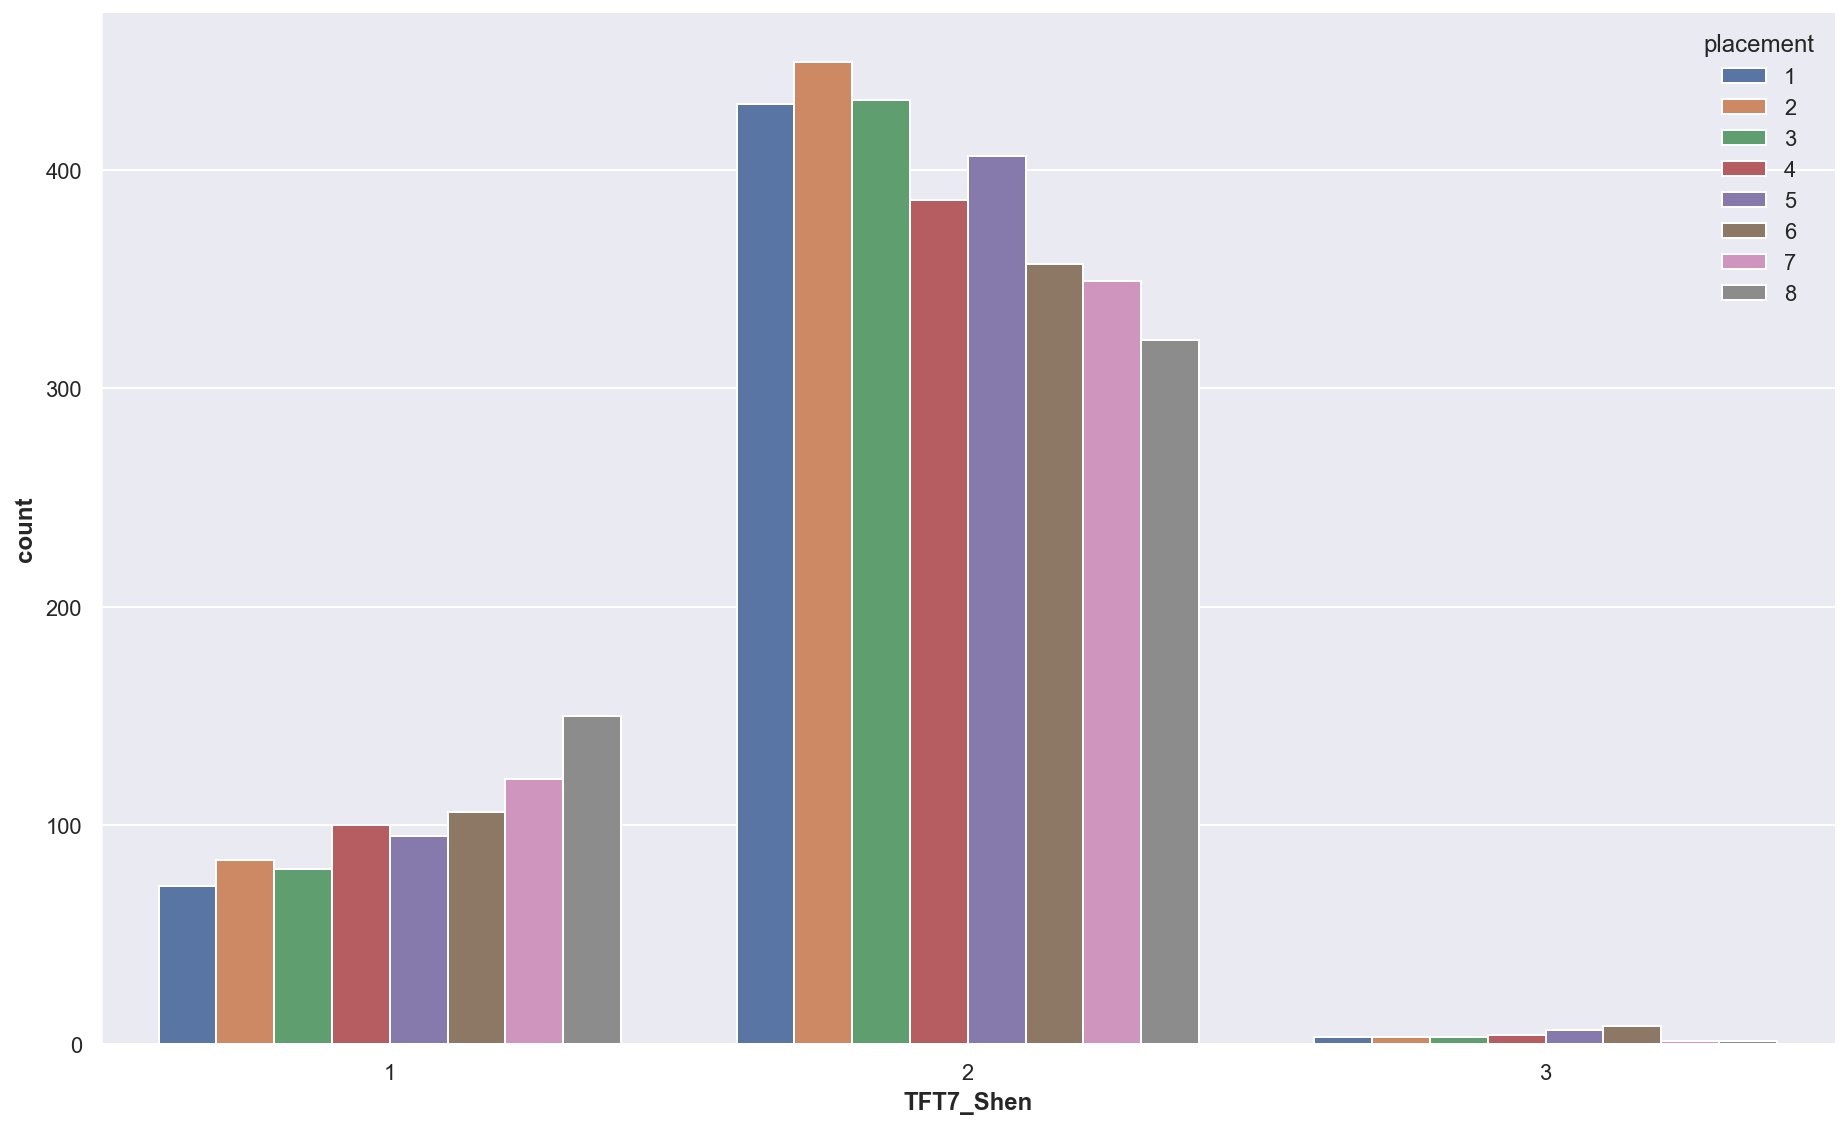

In [758]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Shen']>0], x='TFT7_Shen', hue=TARGETNAME)
sns.despine()

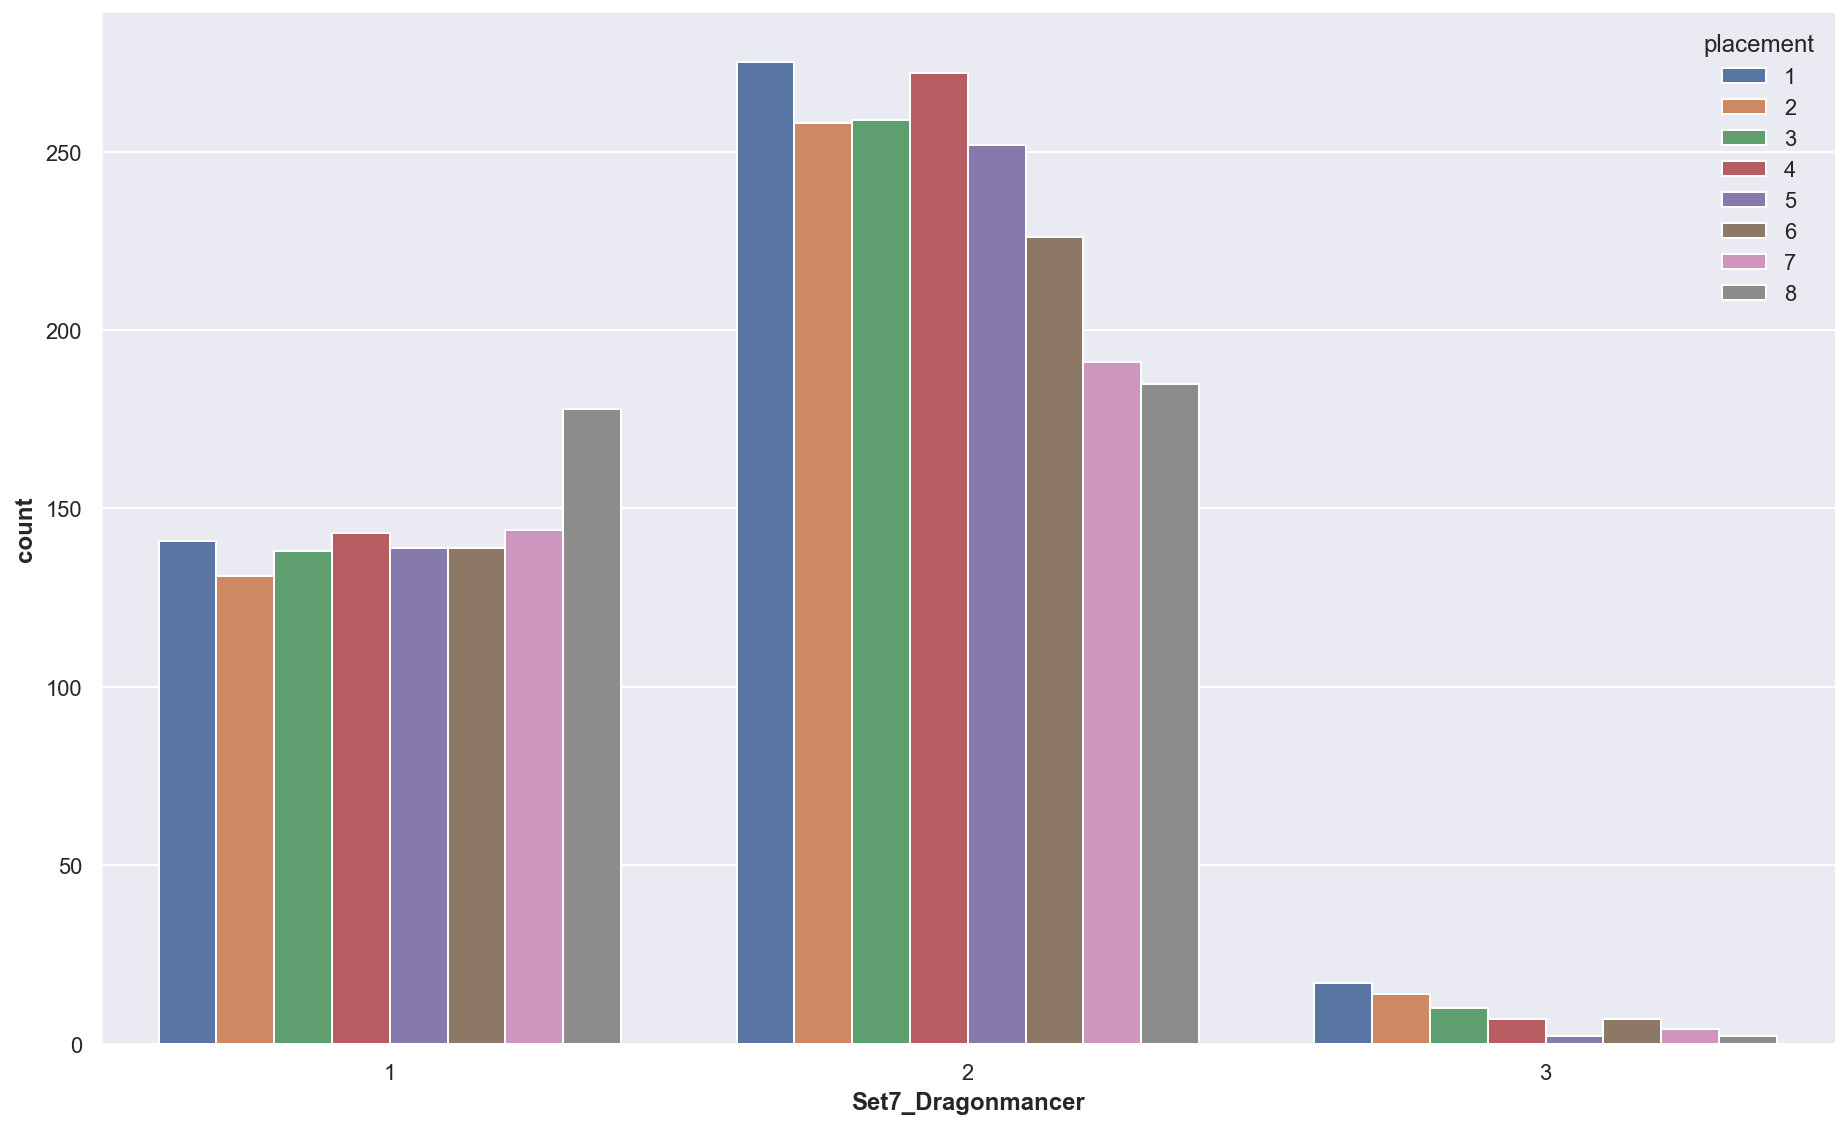

In [759]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Dragonmancer']>0], x='Set7_Dragonmancer', hue=TARGETNAME)
sns.despine()

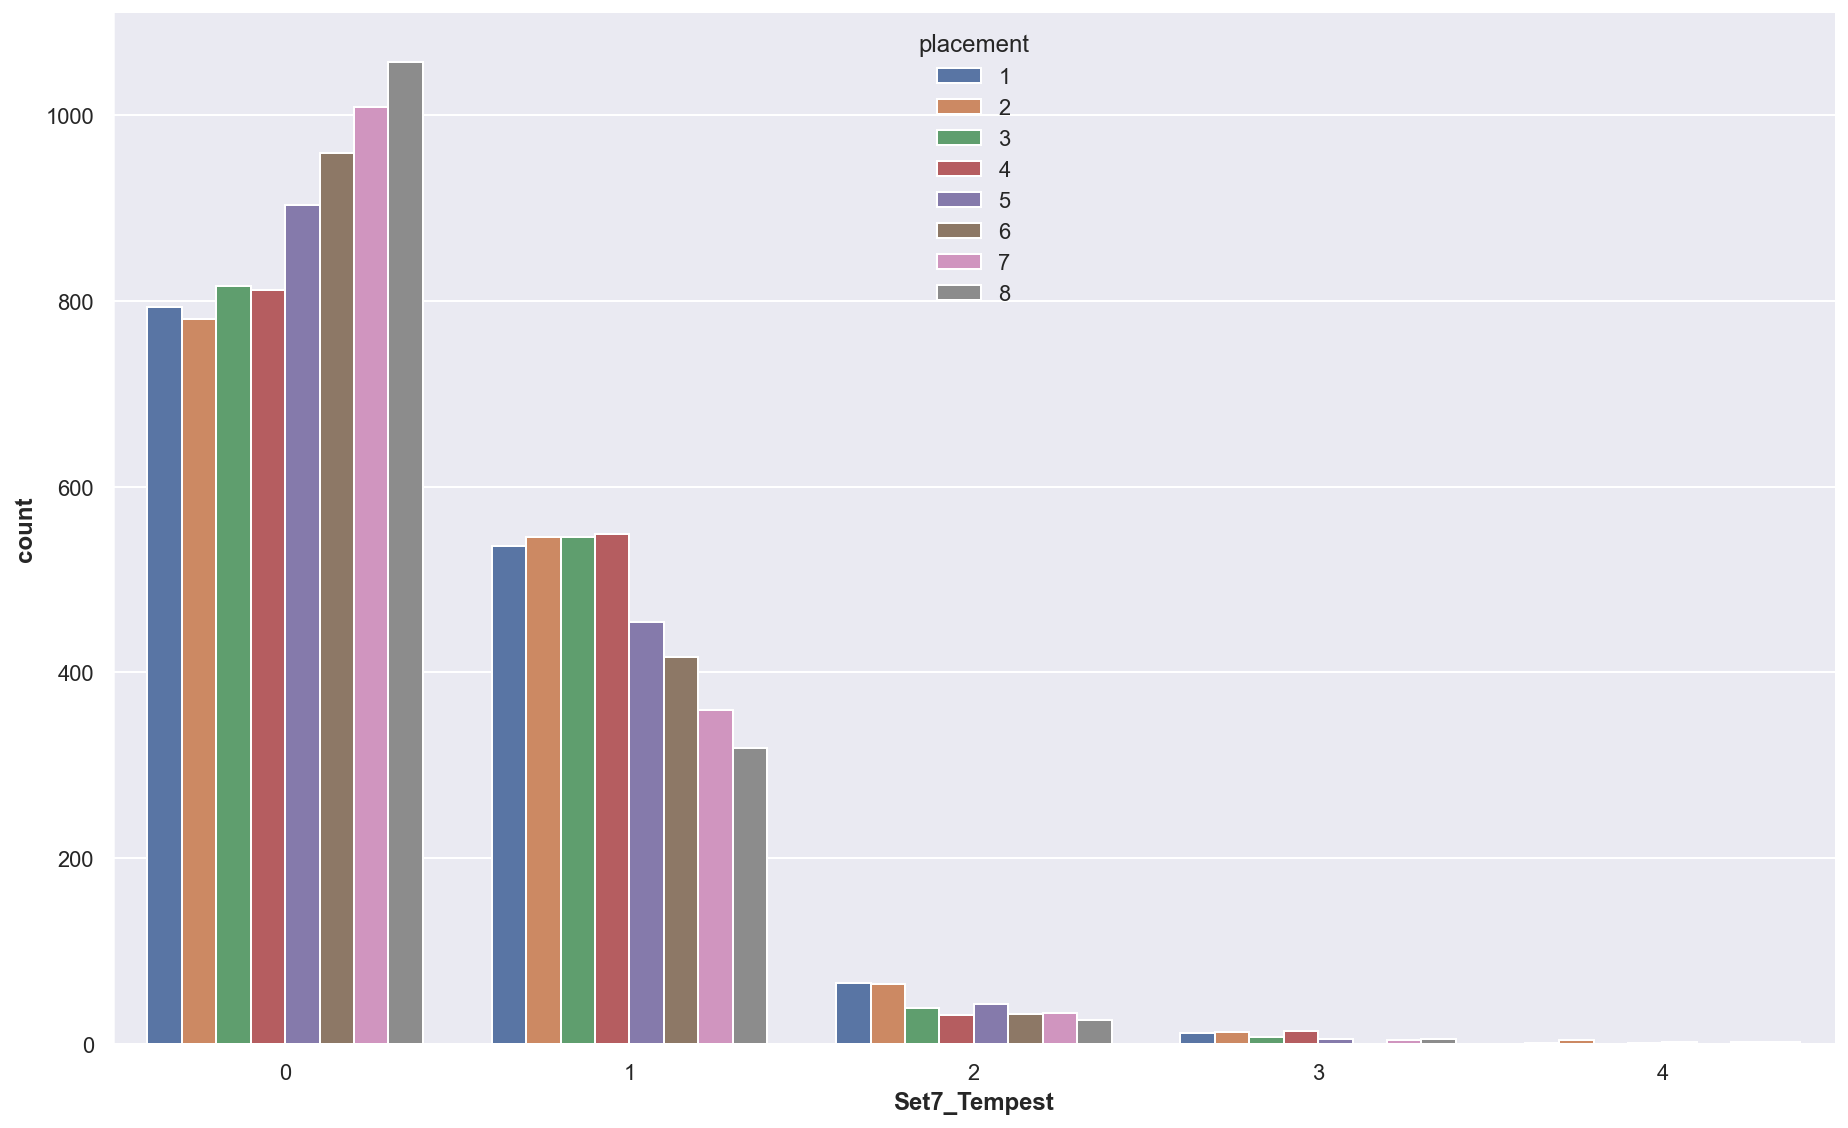

In [760]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Tempest', hue=TARGETNAME)
sns.despine()

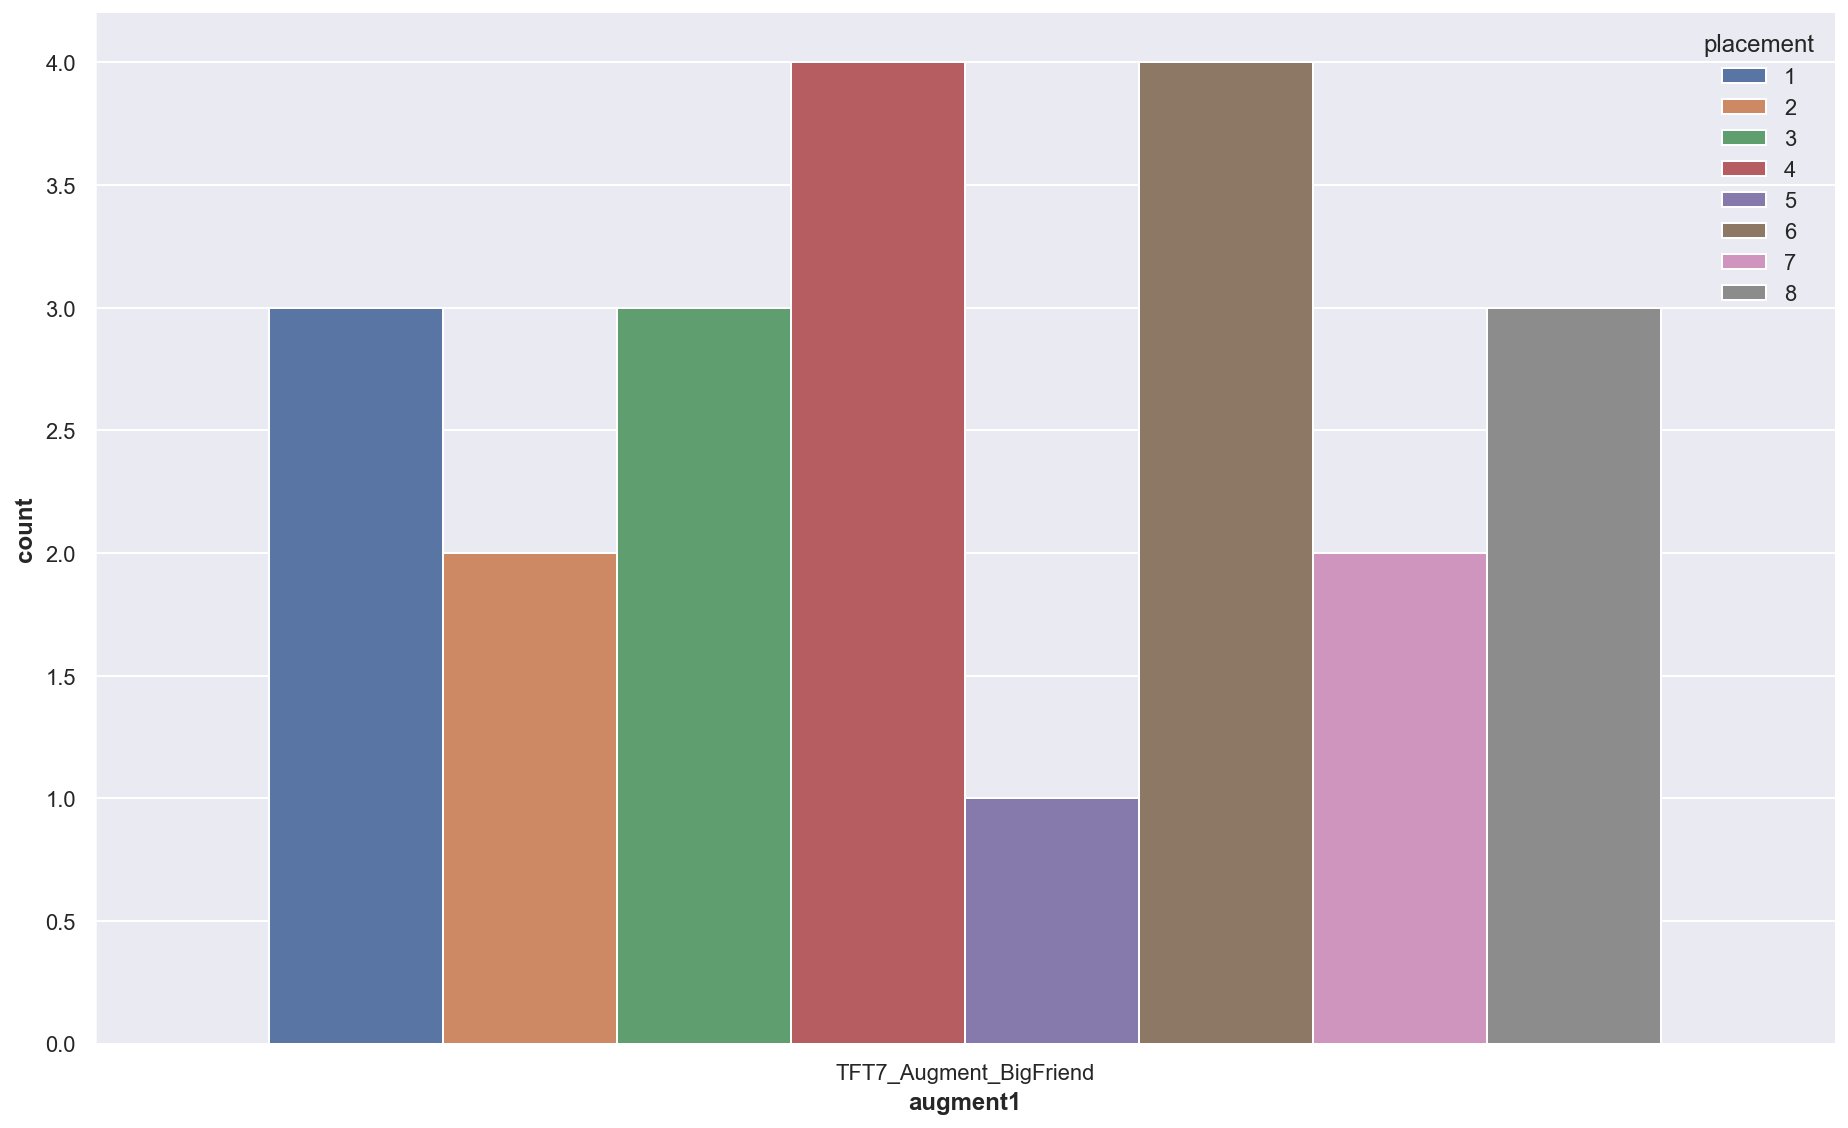

In [761]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['augment1']=='TFT7_Augment_BigFriend'], x='augment1', hue=TARGETNAME)
sns.despine()

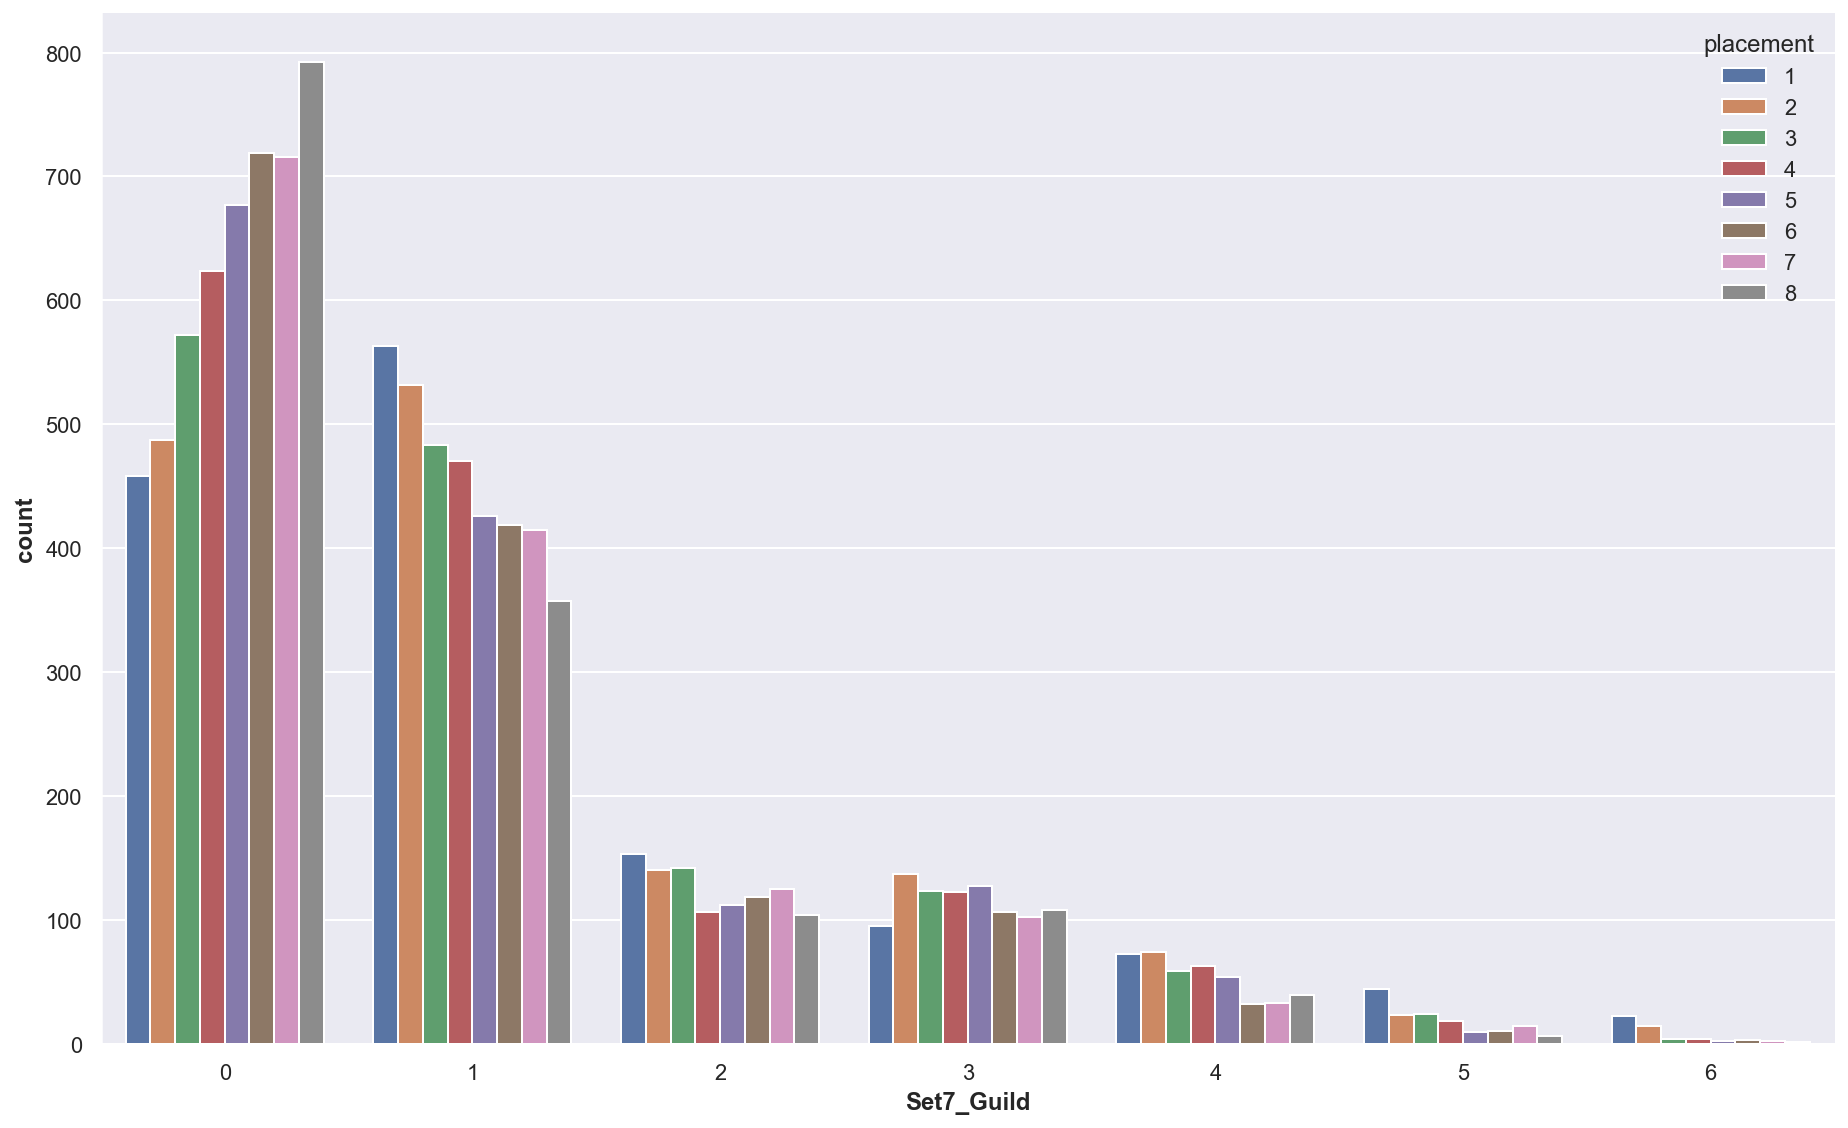

In [786]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Guild', hue=TARGETNAME)
sns.despine()

In [763]:
# X[categorical_cols] = X[categorical_cols].applymap(np.int64)

In [764]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [765]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='mae', tree_method='hist',
                    n_estimators=250, enable_categorical=True) #, use_label_encoder=False hist

In [766]:
le_target = LabelEncoder()

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
augment_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
item_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
preproc = StandardScaler()

# Encode label. 0 = Show , 1 = No Show
y = le_target.fit_transform(y)

In [767]:
# augment_oe.fit(X[categorical_cols[:3]])

In [768]:
# item_oe.fit(X[categorical_cols[3:]])

In [769]:
# categorical_cols[3:]

In [770]:
# Encode category columns.
logistic_regression_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", one_hot_encoder, categorical_cols),
            # ("augment", augment_oe, categorical_cols[:3]),
            # ("item", item_oe, categorical_cols[3:]),
        ],
        remainder=preproc,
        verbose_feature_names_out=False,
    ),
    xgb,
)

In [771]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=42)

logistic_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('one_hot_time',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['augment0', 'augment1',
                                                   'augment2',
                                                   'TFT7_Shen_item0',
                                                   'TFT7_Shen_item1',
                                                   'TFT7_Twitch_item0',
                                                   'TFT7_Talon_item0',
                                                   'TFT7_Talon_item1',
                                                   'TFT7_Talon_item2',
                                                   'TFT7_Xayah_item0',
                                                   'TFT7_Xayah_item1',
                                                   '...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=250, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [772]:
y_pred = logistic_regression_pipeline.predict(X_test)

In [773]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le_target.classes_, columns = le_target.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

In [774]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data = confusion_matrix(le_target.inverse_transform(y_test), y_pred, labels = le_target.classes_), index = le_target.classes_, columns = le_target.classes_)
# plot_cm(cm)

In [775]:
len(y_test)

1689

In [776]:
y_pred.shape

(1689,)

In [812]:
def plot_oof(y_true, y_predict):
    area = (30 * np.random.rand(len(y_predict)))**2 
    # Plot y_true vs. y_pred
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_predict, s=area, color='r', alpha=0.2)
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()

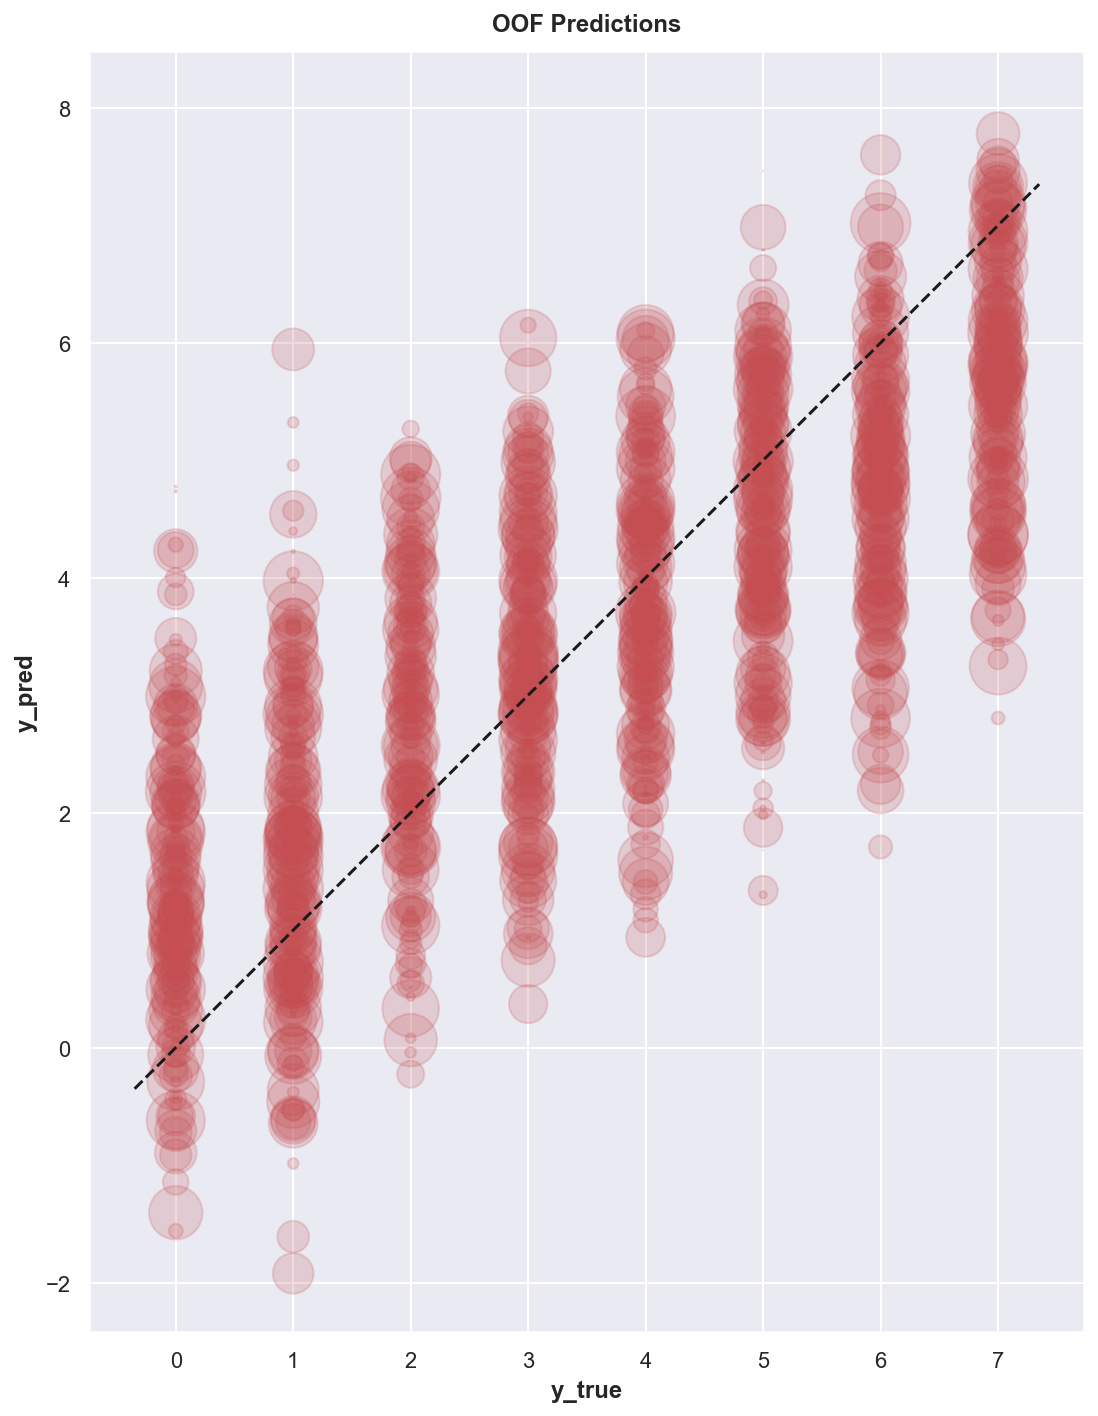

In [813]:
plot_oof(y_test, y_pred)

In [779]:
min(y_pred)

-1.9218384

In [780]:
mean_absolute_error(y_test, y_pred)

1.181738386370127

In [781]:
mean_squared_error(y_test, y_pred)

2.1538207710034927

In [782]:
# logistic_regression_pipeline[:-1].get_feature_names_out()
feature_names = logistic_regression_pipeline[:-1].get_feature_names_out()
mdi_importances = pd.Series(
    logistic_regression_pipeline[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

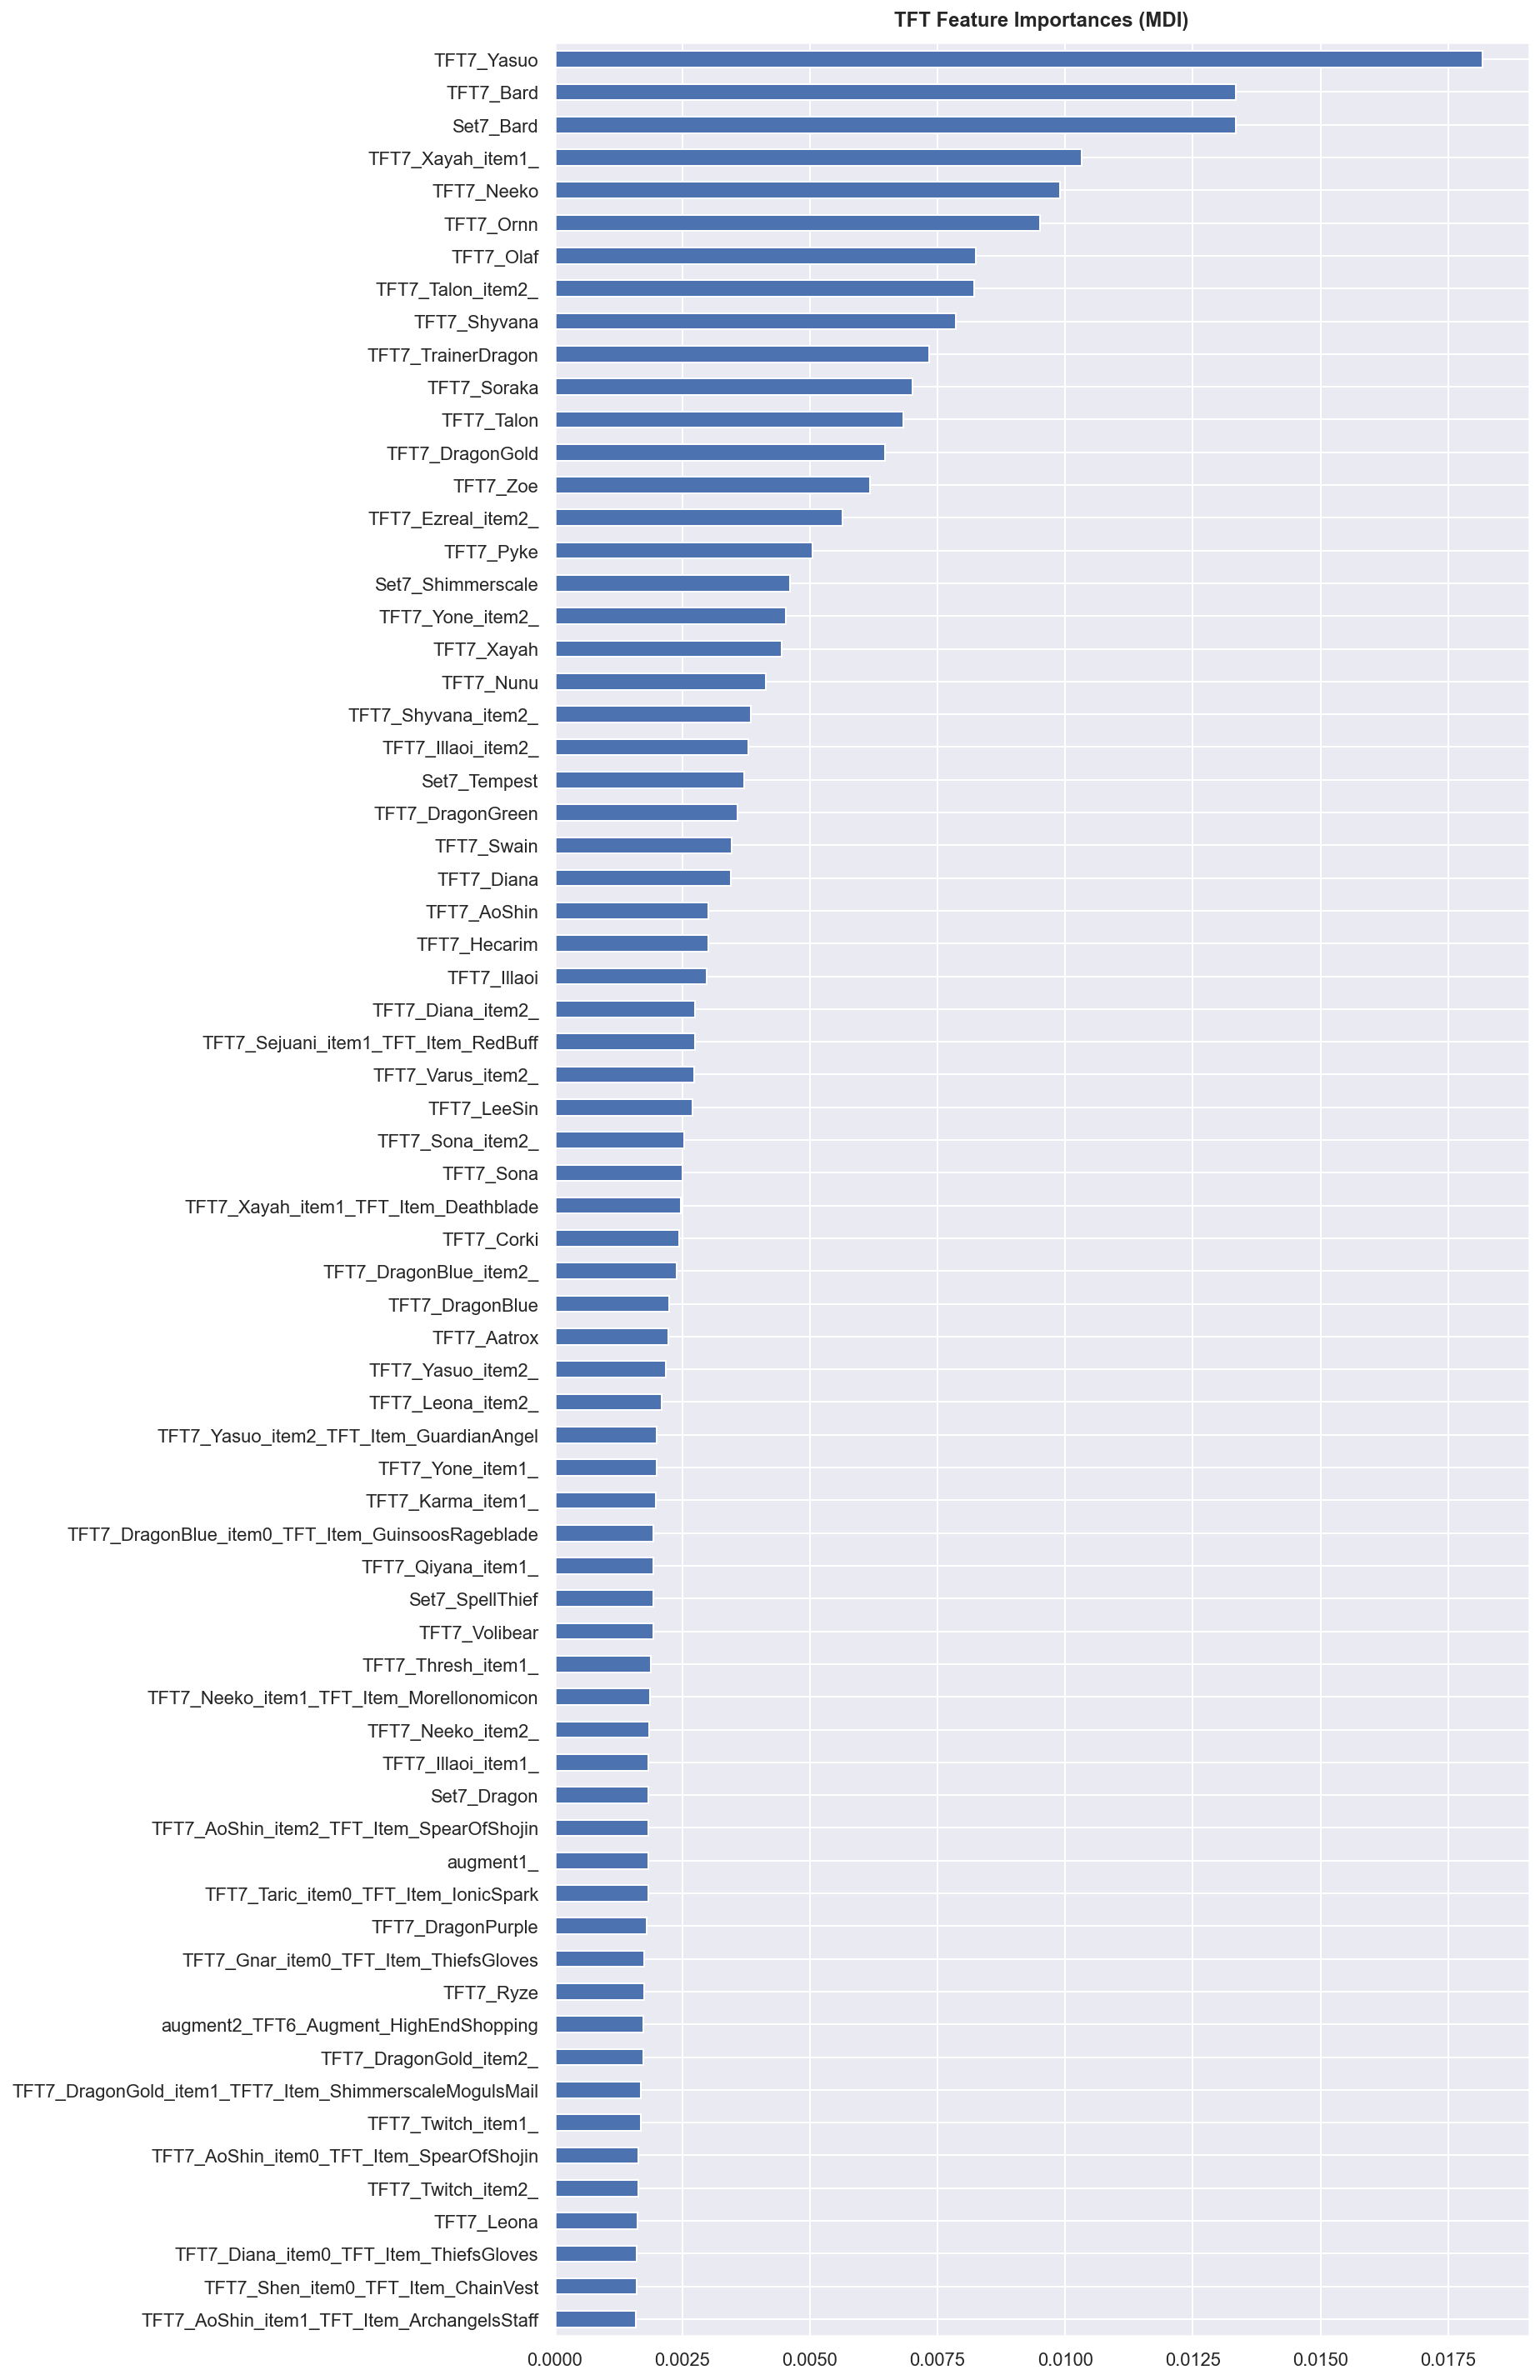

In [783]:
plt.figure(figsize=(13, 20))
ax = mdi_importances[-70:].plot.barh()
ax.set_title("TFT Feature Importances (MDI)")
ax.figure.tight_layout()

In [784]:
mdi_importances.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_mdi_importances.csv'))

In [785]:
mdi_importances[-60:]

TFT7_Ryze                                           0.001753
TFT7_Gnar_item0_TFT_Item_ThiefsGloves               0.001761
TFT7_DragonPurple                                   0.001811
TFT7_Taric_item0_TFT_Item_IonicSpark                0.001832
augment1_                                           0.001835
TFT7_AoShin_item2_TFT_Item_SpearOfShojin            0.001841
Set7_Dragon                                         0.001842
TFT7_Illaoi_item1_                                  0.001843
TFT7_Neeko_item2_                                   0.001845
TFT7_Neeko_item1_TFT_Item_Morellonomicon            0.001873
TFT7_Thresh_item1_                                  0.001886
TFT7_Volibear                                       0.001929
Set7_SpellThief                                     0.001936
TFT7_Qiyana_item1_                                  0.001937
TFT7_DragonBlue_item0_TFT_Item_GuinsoosRageblade    0.001939
TFT7_Karma_item1_                                   0.001976
TFT7_Yone_item1_        